# Анализ энергий

In [1]:
from analys.energy import Staticstics
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class atom():
    '''
    Параметры конкретного атома
    '''
    def __init__(self, 
                 data,
                 molecule = 0, 
                 atom = 0,
                 **kwargs):
        
        self.molecule = molecule
        self.atom = atom
        self.coord = self.get_matrix(data, 0)
        self.vel = self.get_matrix(data, 1)
        
    def get_matrix(self, data, delta):
        ''' 
        deltadelta = 0 --- coordinates
        delta = 1 --- velocities
        molecule/atom --- numbers 0,1
        '''
        start_index = self.molecule * 12 + self.atom * 6 + delta
        
        v1 = []
        for ind in range(start_index, start_index + 6, 2):
            v1.append(data[ind])
        
        return np.array(v1)

In [3]:
class molecule():
    def __init__(self,
                 data,
                 molecule=0, 
                 k=105734.2419441007825, 
                 unstretched = 0.32932330827068):
        '''
        > Параметры:
        >>> k - жесткость "пружины" в молекуле;
        >>> unstretched --- расстояние между атомами при релаксации;
        '''
        self.k = k
        self.unstretched = unstretched
        self.atom0 = atom(data, molecule, 0)
        self.atom1 = atom(data, molecule, 1)
        self.vel = self.center_molecular_vel()
        self.coord = self.center_molecular_coord()
        self.M = 2.
        
    def center_molecular_vel(self):
        return (self.atom0.vel + self.atom1.vel) / 2.
    
    def center_molecular_coord(self):
        return (self.atom0.coord + self.atom1.coord) / 2.

    def interatomic_distance(self):
        return np.sqrt(np.sum((self.atom0.coord - self.atom1.coord) ** 2, axis = 0))
        
    def V_in(self):
        '''
        Потенциальная энергия V = k * (r - r0)^2
        '''
        dist = self.interatomic_distance()
    
        return self.k * ((dist - self.unstretched) ** 2)
    

    def T(self, mv = 0.0):
        '''
        Кинетическая энергия молекулы T = v^2/2
        Параметры:
        >>> mv --- скорость центра масс системы,
        >>> (т.е. для подсчёта без неё)
        '''
        vel0 = self.atom0.vel - mv
        vel1 = self.atom1.vel - mv
        return  0.5  *(np.sum(vel0 ** 2, axis = 0) + np.sum(vel1 ** 2, axis = 0))
    
    def T_c(self, mv = 0.0):
        '''
        Кинетическая энергия центра масс молекулы
        '''
        return self.M * np.sum((self.vel - mv) ** 2, axis = 0) / 2.

    def T_in(self, mv = 0.0):
        '''
        Внутренняя кинетическая энергия молекулы
        '''
        # остались скорости
        v1 = self.atom0.vel - self.vel
        v2 = self.atom1.vel - self.vel
        return np.sum(v1 **2 + v2 **2, axis = 0)/2
        
    
    def Full_Energy(self, mv=0.0):
        ''' 
        полная энергия в молекуле
        '''
        return self.T(mv) + self.V_in()
    
    
    def Divided_energy(self):
        '''
        Разделим энергию на составляющие: forward, vibrational, rational 
        '''
        
        forward = self.M * np.sum(self.vel * self.vel, axis = 0) / 2.
        
        # остались скорости
        v1 = self.atom0.vel - self.vel
        v2 = self.atom1.vel - self.vel
        T_in = np.sum(v1 **2 + v2 **2, axis = 0)/2
        
        # найдём вектор между двумя атомами
        vec = self.atom1.coord - self.atom0.coord
        dist = self.interatomic_distance()
        # проецируем скорости на этот вектор 
        v1_pr = (np.sum(v1 * vec, axis=0) / dist) * (vec / dist )
        v2_pr = (np.sum(v2 * vec, axis=0) / dist) * (vec / dist)

        #колебательная энергия
        vibrational = np.sum((v1_pr * v1_pr + v2_pr * v2_pr), axis = 0) / 2.0 + self.V_in()
        
        v1_r = v1 - v1_pr
        v2_r = v2 - v2_pr
        rational = np.sum((v1_r * v1_r + v2_r * v2_r)/2.0, axis = 0) 

        return forward, rational, vibrational

In [4]:
class molecular_system():
    def __init__(self, data, 
                 k=105734.2419441007825, 
                 unstretched = 0.32932330827068):
        
        self.m0 = molecule(data, 0, k, unstretched)
        self.m1 = molecule(data, 1, k, unstretched)
        self.vel = self.center_vel()
        self.coord = self.center_coord()
        self.M = 4.
        self.m_r = (2. * 2.)/ (2.+2.)
        self.c_r = self.relative_velocity()
        
    def center_vel(self):
        '''
        Скорость центра масс системы
        '''
        return (self.m0.vel + self.m1.vel) / 2.
    
    def center_coord(self):
        '''
        Координаты центра масс системы
        '''
        return (self.m0.coord + self.m1.coord) / 2.

    def intermolecular_distance(self):
        '''
        Расстояние между молекулами
        '''
        return np.sqrt(np.sum((self.m0.coord - self.m1.coord) ** 2, axis = 0))    

    def relative_velocity(self):
        '''c_r'''
        return self.m1.vel - self.m0.vel
    
    def relative_velocity_len(self):
        '''c_r'''
        return np.sqrt(np.sum(self.c_r ** 2, axis = 0))

    
    @staticmethod
    def dist2(ri,rj):
        ''' Расстояние между атомами '''
        return np.sum((ri - rj)**2, axis=0)

    
    def V_in(self):
        return self.m0.V_in() +  self.m1.V_in()
    
    
    def LD(self):
        '''
        Потенциал ЛД
        '''
        result = 0.0
        
        dist = self.dist2(self.m0.atom0.coord,self.m1.atom0.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
        
        dist = self.dist2(self.m0.atom0.coord,self.m1.atom1.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
        
        dist = self.dist2(self.m0.atom1.coord,self.m1.atom0.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
        
        dist = self.dist2(self.m0.atom1.coord,self.m1.atom1.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
                
        return 4 * result

    def Full_Energy(self):
        '''
        Полная энергия системы
        '''
        return self.m0.Full_Energy() + self.m1.Full_Energy()  + self.LD()
    
    
    def Full_Energy_r(self):
        '''
        Полная энергия системы за вычетом Кинетической энергии движения центра масс системы
        '''
        return self.Full_Energy() - self.T_c()  #self.m0.V_in() + self.m1.V_in()  + self.LD() +self.T_r()
    
    def Full_Energy_rt(self):
        '''
        Полная энергия системы за вычетом Кинетической энергии движения центра масс системы
        и внутренней кинетической энергии молекулы
        '''
        return self.Full_Energy() - self.T_c() - self.T_in() #self.m0.V_in() + self.m1.V_in()  + self.LD() +self.T_r()

    def T_r(self):
        '''
        Кинетическая энергия отнсительнго движения
        '''
        return self.m_r * np.sum((self.c_r  ** 2), axis=0) / 2.
    
    def T_c(self):
        '''
        Кинетическая энергия центра масс системы
        '''
        return self.M * np.sum( (self.vel ** 2) , axis = 0)/ 2.

    
    def T_in(self):
        ''' 
        Внутренняя кинетическая энергия молекулы
        '''
        return self.m0.T_in() + self.m1.T_in() 
        
    def T(self):
        '''
        Полная кинетическая энергия системы
        '''
        return self.m0.T() + self.m1.T() 
    
    def Divided_energy(self):
        forward, rational, vibrational = self.m0.Divided_energy()
        forward1, rational1, vibrational1 = self.m1.Divided_energy()
        return forward + forward1, rational + rational1, vibrational + vibrational1
    
    def length_vel(self):
        return np.sqrt(np.sum(self.vel ** 2, axis = 0))

In [5]:
class calc_system():
    def __init__(self, 
                 aiming = "0.00", num = "0", PATH =  "1/out_8/",
                 k=105734.2419441007825, 
                 unstretched = 0.32932330827068):
        
        data_init, data_end = self.get_data(aiming, num, PATH)
        self.s1 = molecular_system(data_init, k, unstretched)
        self.s2 = molecular_system(data_end, k, unstretched)
        
    @staticmethod
    def to_num(init):
        for i in range(24):
            init[i] = pd.to_numeric(init[i])        
        return init    
    
    def get_data(self, aiming, num, PATH):
        init = pd.read_csv(PATH + 'aiming_{0}/init/file_{1}.csv'.format(aiming, num), sep='\t',header=None)
        end = pd.read_csv(PATH + 'aiming_{0}/LF/file_{1}.csv'.format(aiming, num), sep='\t',header=None)

        del init[24]
        del end[24]

        init = init[~init.isin([np.nan, np.inf, -np.inf, "-nan(ind)"]).any(1)]
        end = end[~end.isin([np.nan, np.inf, -np.inf, "-nan(ind)"]).any(1)]
        init, end = self.to_num(init), self.to_num(end)
        return init, end

    def angle(self):
        return np.mean(np.sum(self.s1.vel * self.s2.vel, axis = 0)/(self.s1.length_vel() * self.s2.length_vel()))
    
    def diff_c_r(self):
        return self.s1.vel - self.s2.vel
    
    def lmbd(self):
        '''Лямбда'''
        return  np.sum(self.s1.T_r()) / np.sum(self.s1.Full_Energy_r()),\
                np.sum(self.s2.T_r()) / np.sum(self.s2.Full_Energy_r())
        
    def lmbd_1(self):
        '''Лямбда без внутренней кинетической энергии'''
        return  np.sum(self.s1.T_r()) / np.sum(self.s1.Full_Energy_rt()),\
                np.sum(self.s2.T_r()) / np.sum(self.s2.Full_Energy_rt())
    
    def Full_Energy(self):
        return self.s1.Full_Energy(),  self.s2.Full_Energy()
    
    def V_in(self):
        return self.s1.V_in(), self.s2.V_in()
    
    
    def LD(self):
        return self.s1.LD(),  self.s2.LD()
    
    
    def Kinetik(self):
        return  self.s1.T_in(),\
                self.s1.T_c(),\
                self.s1.T_r(),\
                self.s1.T(),\
                self.s2.T_in(),\
                self.s2.T_c(),\
                self.s2.T_r(),\
                self.s2.T()

In [6]:
def process_full(PATH = "1/out_8/",
                 END_FILE_NUM = 2,
                 START_b = 0.0, 
                 END_b = 2.1, 
                 step_b = 0.2):
    '''
    Соберём следующие статистические параметры:
     1. Перераспределение T_in, T_c, T_r, H, LD, V_in, T
    '''
    
    result_v = {}
    result_b = {}
    
    for b in tqdm(np.arange(START_b, END_b, step_b)):
        b_in = "%.1lf"%(b) + "0" 
        
        for v in range(END_FILE_NUM):
            v_in = str(v)
            s = calc_system(b_in, v_in, PATH)
            
            
            # T
            T_in_1, T_c_1, T_r_1, T_1,T_in_2, T_c_2, T_r_2, T_2 = s.Kinetik()
            
            H1, H2 = s.Full_Energy()
            LD1, LD2 = s.LD()
            V1, V2 = s.V_in()
            
            c_r_i = np.mean(s.s1.relative_velocity_len())
            
            c_r_i_str = "%0.1lf"%(c_r_i)
            
            b_str = "%0.1lf"%(b)
            Fw1,Rot1,Vib1 = s.s1.Divided_energy()
            Fw2,Rot2,Vib2 = s.s2.Divided_energy()
            if c_r_i_str not in result_v:
                result_v[c_r_i_str] = {}
                result_v[c_r_i_str]['b'] = []
                result_v[c_r_i_str]['T_in_1'] = []          
                result_v[c_r_i_str]['T_c_1'] = []        
                result_v[c_r_i_str]['T_r_1'] = []          
                result_v[c_r_i_str]['T_1'] = []    
                
                result_v[c_r_i_str]['T_in_2'] = []          
                result_v[c_r_i_str]['T_c_2'] = []        
                result_v[c_r_i_str]['T_r_2'] = []          
                result_v[c_r_i_str]['T_2'] = []      
                
                result_v[c_r_i_str]['H1'] = []          
                result_v[c_r_i_str]['H2'] = []    
                
                result_v[c_r_i_str]['LD1'] = []          
                result_v[c_r_i_str]['V1'] = []   
                result_v[c_r_i_str]['LD2'] = []          
                result_v[c_r_i_str]['V2'] = []  
                
                
                result_v[c_r_i_str]['Fw1'] = []          
                result_v[c_r_i_str]['Rot1'] = []   
                result_v[c_r_i_str]['Vib1'] = [] 
                
                result_v[c_r_i_str]['Fw2'] = []          
                result_v[c_r_i_str]['Rot2'] = []   
                result_v[c_r_i_str]['Vib2'] = []      
                
            if b_str not in result_b:
                result_b[b_str] = {}
                result_b[b_str]['v'] = []
                
                result_b[b_str]['T_in_1'] = []          
                result_b[b_str]['T_c_1'] = []        
                result_b[b_str]['T_r_1'] = []          
                result_b[b_str]['T_1'] = []    
                
                result_b[b_str]['T_in_2'] = []          
                result_b[b_str]['T_c_2'] = []        
                result_b[b_str]['T_r_2'] = []          
                result_b[b_str]['T_2'] = [] 
                
                result_b[b_str]['H1'] = []          
                result_b[b_str]['H2'] = []   
                
                result_b[b_str]['LD1'] = []     
                result_b[b_str]['V1'] = []      
                result_b[b_str]['LD2'] = []          
                result_b[b_str]['V2'] = []   
                  
                result_b[b_str]['Fw1'] = []      
                result_b[b_str]['Rot1'] = []          
                result_b[b_str]['Vib1'] = [] 
                
                result_b[b_str]['Fw2'] = []      
                result_b[b_str]['Rot2'] = []          
                result_b[b_str]['Vib2'] = [] 
            
            # добавляем свойства по c_r
            result_v[c_r_i_str]['b'].append(b)

            result_v[c_r_i_str]['T_in_1'].append(T_in_1)          
            result_v[c_r_i_str]['T_c_1'].append(T_c_1)        
            result_v[c_r_i_str]['T_r_1'].append(T_r_1)           
            result_v[c_r_i_str]['T_1'].append(T_1)    

            result_v[c_r_i_str]['T_in_2'].append(T_in_2)     
            result_v[c_r_i_str]['T_c_2'].append(T_c_2)      
            result_v[c_r_i_str]['T_r_2'].append(T_r_2)       
            result_v[c_r_i_str]['T_2'].append(T_2)   
            
            result_v[c_r_i_str]['H1'].append(H1)       
            result_v[c_r_i_str]['H2'].append(H2) 
            
            result_v[c_r_i_str]['LD1'].append(LD1)       
            result_v[c_r_i_str]['LD2'].append(LD2) 
            
            result_v[c_r_i_str]['V1'].append(V1)       
            result_v[c_r_i_str]['V2'].append(V2)
            
            result_v[c_r_i_str]['Fw1'].append(Fw1)       
            result_v[c_r_i_str]['Rot1'].append(Rot1) 
            result_v[c_r_i_str]['Vib1'].append(Vib1)
            result_v[c_r_i_str]['Fw2'].append(Fw2)       
            result_v[c_r_i_str]['Rot2'].append(Rot2) 
            result_v[c_r_i_str]['Vib2'].append(Vib2)
            
            
            # добавляем свойства по b
            result_b[b_str]['v'].append(c_r_i)

            result_b[b_str]['T_in_1'].append(T_in_1)          
            result_b[b_str]['T_c_1'].append(T_c_1)       
            result_b[b_str]['T_r_1'].append(T_r_1)         
            result_b[b_str]['T_1'].append(T_1)   

            result_b[b_str]['T_in_2'].append(T_in_2)        
            result_b[b_str]['T_c_2'].append(T_c_2)     
            result_b[b_str]['T_r_2'].append(T_r_2)      
            result_b[b_str]['T_2'].append(T_2)     
            
            result_b[b_str]['H1'].append(H1)      
            result_b[b_str]['H2'].append(H2)     
            result_b[b_str]['LD1'].append(LD1)      
            result_b[b_str]['LD2'].append(LD2)     
            result_b[b_str]['V1'].append(V1)      
            result_b[b_str]['V2'].append(V2)   
            
            result_b[b_str]['Fw1'].append(Fw1)     
            result_b[b_str]['Rot1'].append(Rot1)      
            result_b[b_str]['Vib1'].append(Vib1)  
            result_b[b_str]['Fw2'].append(Fw2)     
            result_b[b_str]['Rot2'].append(Rot2)      
            result_b[b_str]['Vib2'].append(Vib2)        
            
    
    return result_v, result_b

# Подсчёт параметров

In [7]:
def update(old, new):
    for key in new.keys():
        if key not in old.keys():
            old[key] = {}
            
        for in_key in new[key].keys():
            
            if in_key not in old[key].keys():
                old[key][in_key] = []
            
            old[key][in_key] += new[key][in_key]
    return old

In [15]:
result_v = {}
result_b = {}

v,b = process_full()

result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="2/out_2/", 
                   END_FILE_NUM=3,
                   END_b = 1.9)
result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="3/out_1/", 
                   END_FILE_NUM=5,
                   END_b = 1.9)
result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="4/out_3/", 
                       END_FILE_NUM=9,
                       END_b = 1.9)
result_v = update(result_v, v)
result_b = update(result_b, b)


v,b = process_full(PATH="out/", 
                   END_FILE_NUM=19,
                   START_b = 2.0,
                   END_b = 3.5)
result_v = update(result_v, v)
result_b = update(result_b, b)

100%|██████████| 8/8 [00:25<00:00,  3.13s/it]


In [16]:
def arraying(arr):
    for i in arr:
        for j in arr[i]:
            arr[i][j] = np.array(arr[i][j])
    return arr

result_v = arraying(result_v)
result_b = arraying(result_b)

# Энергетический анализ

1. Построим графики $\Delta T_{in}(c_r)$,  $\Delta T_{r}(c_r)$, $\Delta T_{c}(c_r)$,$\Delta H(c_r)$ где 
$$ \Delta F = \frac{F_{init} - F_{end}}{F}$$
где H - полная энергия, 
2. Построим графики $T_{in}(c_r)$,  $ T_{r}(c_r)$, $ T_{c}(c_r)$



______________________________________________________________________________________________
dH =  -0.0004203603768025293


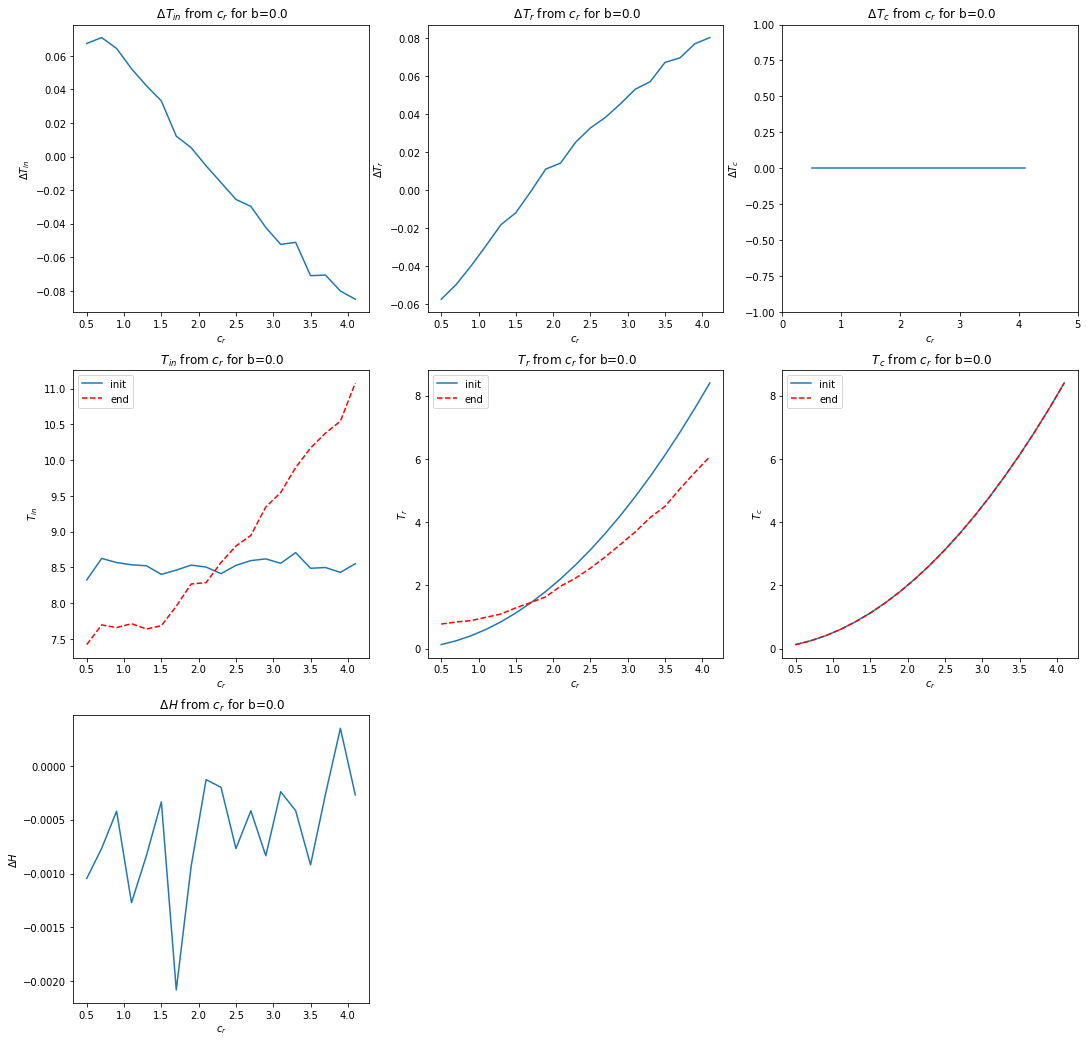

______________________________________________________________________________________________
dH =  -0.0006524898171561488


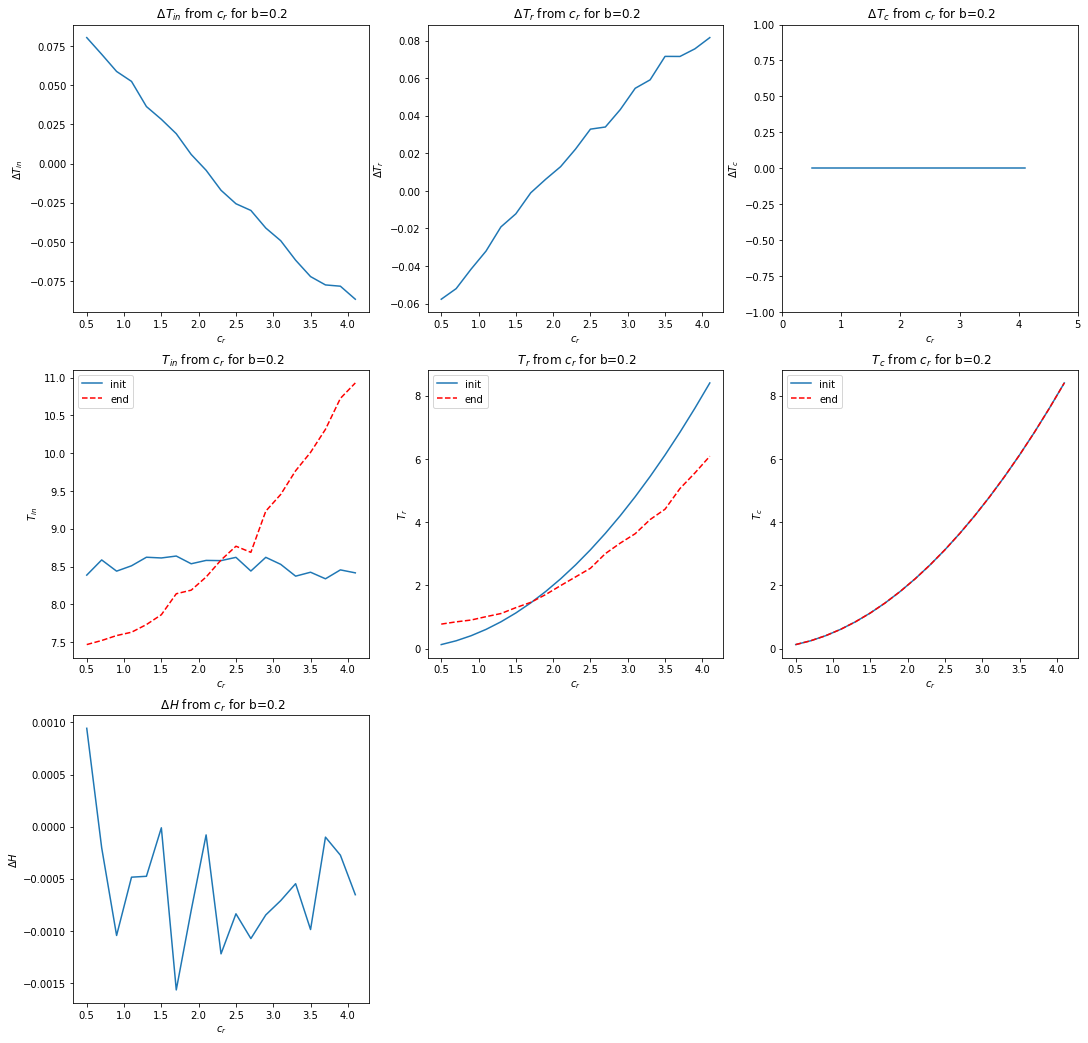

______________________________________________________________________________________________
dH =  -0.0007207898294572562


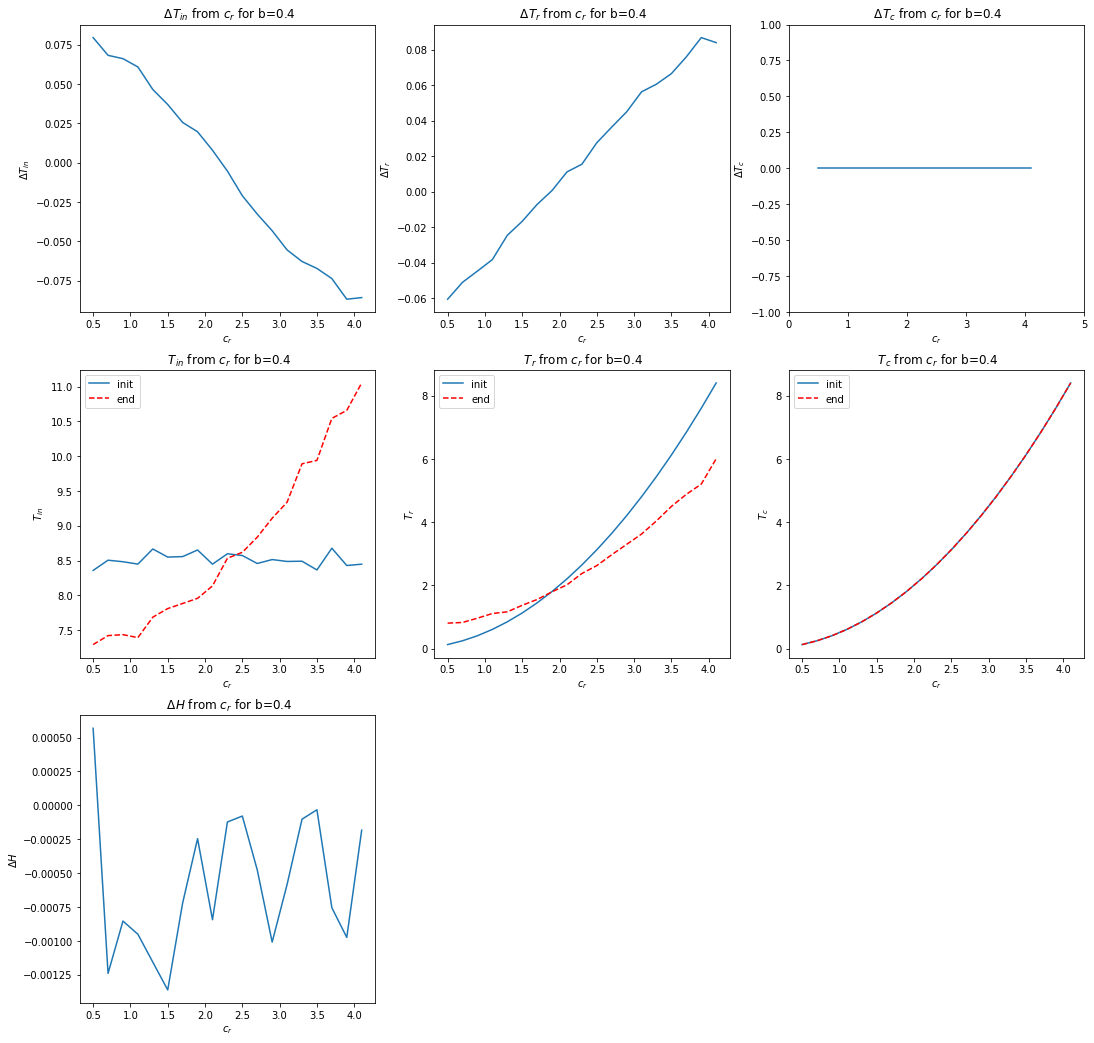

______________________________________________________________________________________________
dH =  -0.0003151030479723565


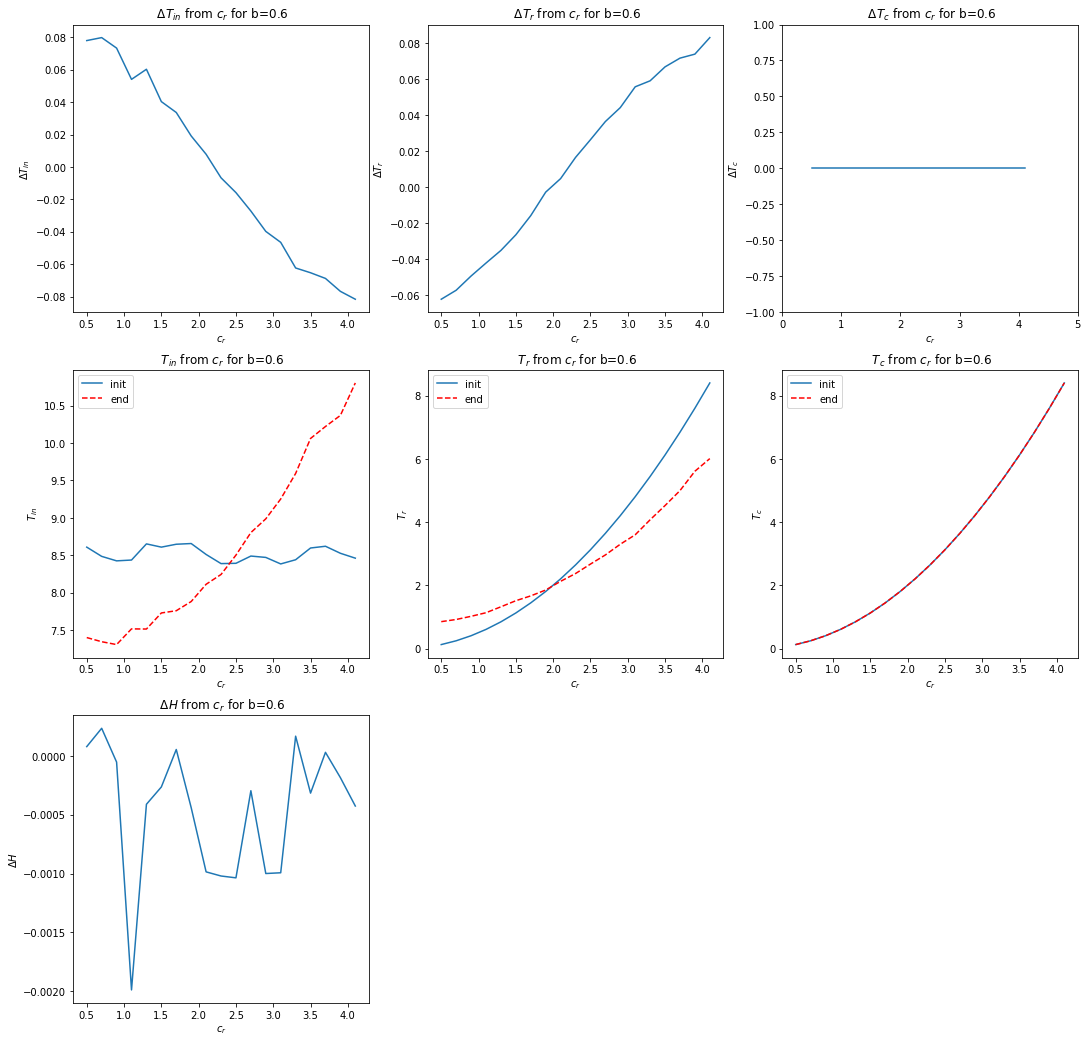

______________________________________________________________________________________________
dH =  -0.0002573241976596488


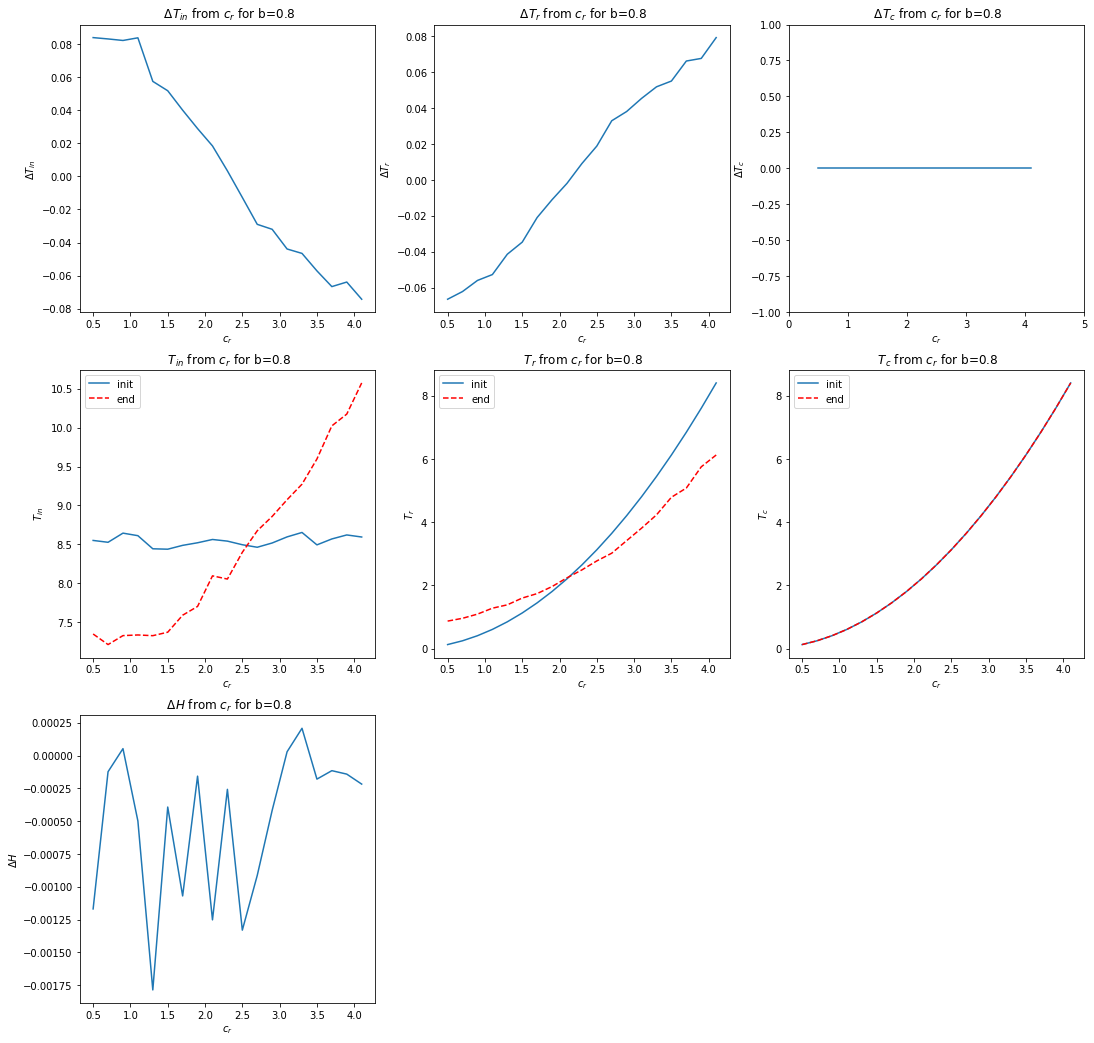

______________________________________________________________________________________________
dH =  -0.0008843829403161393


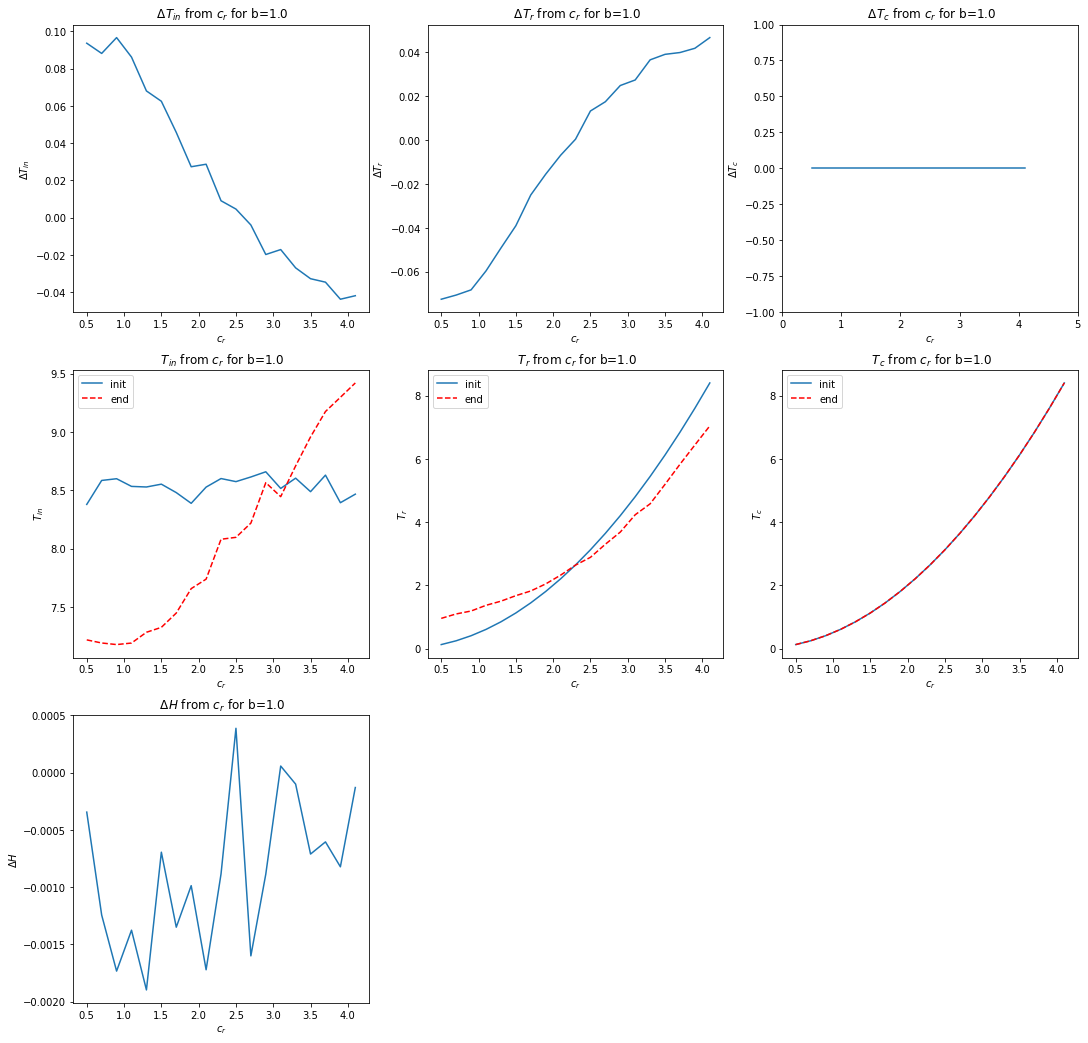

______________________________________________________________________________________________
dH =  -0.0004949765382604354


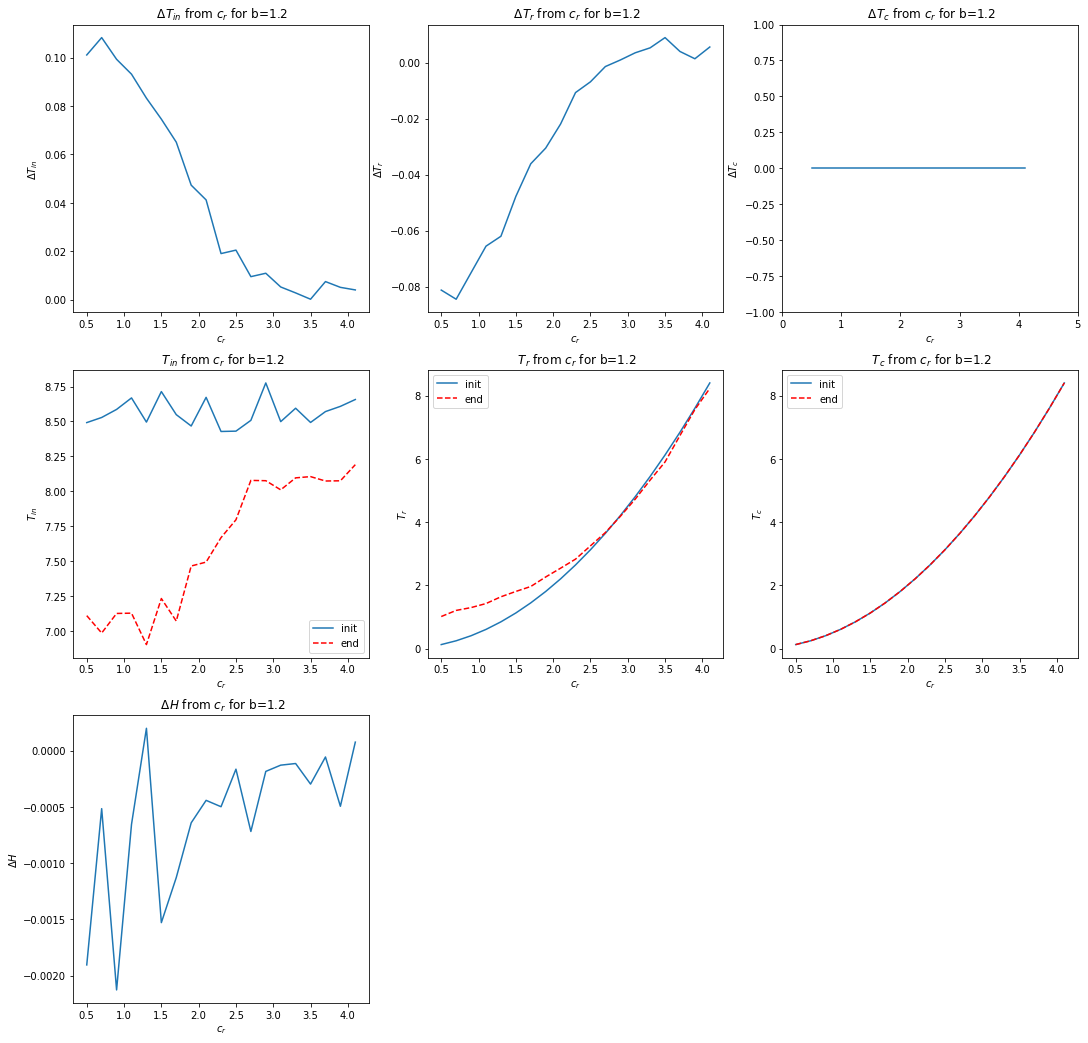

______________________________________________________________________________________________
dH =  -0.0004729141703977365


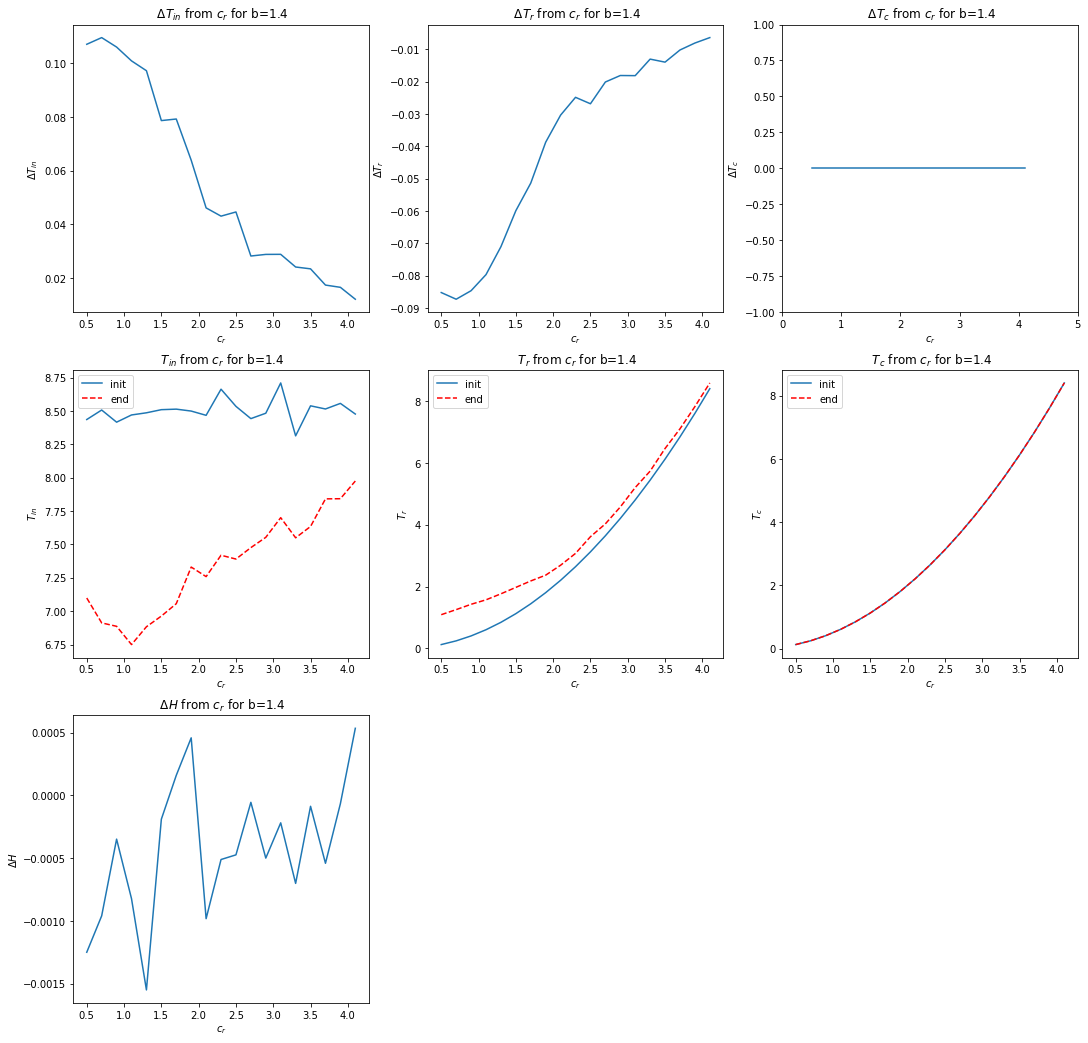

______________________________________________________________________________________________
dH =  -0.0004277497130616557


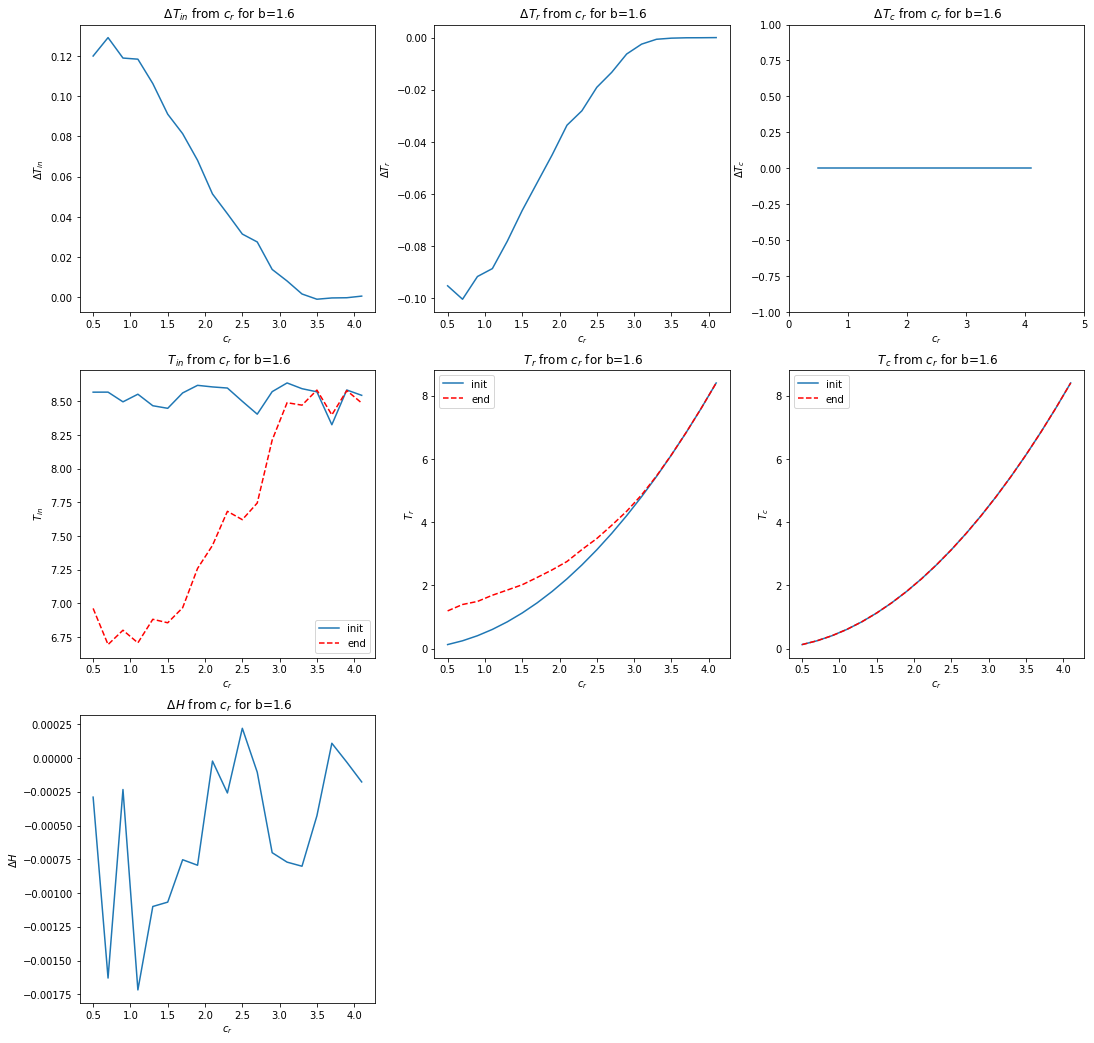

______________________________________________________________________________________________
dH =  -0.00021287413993906876


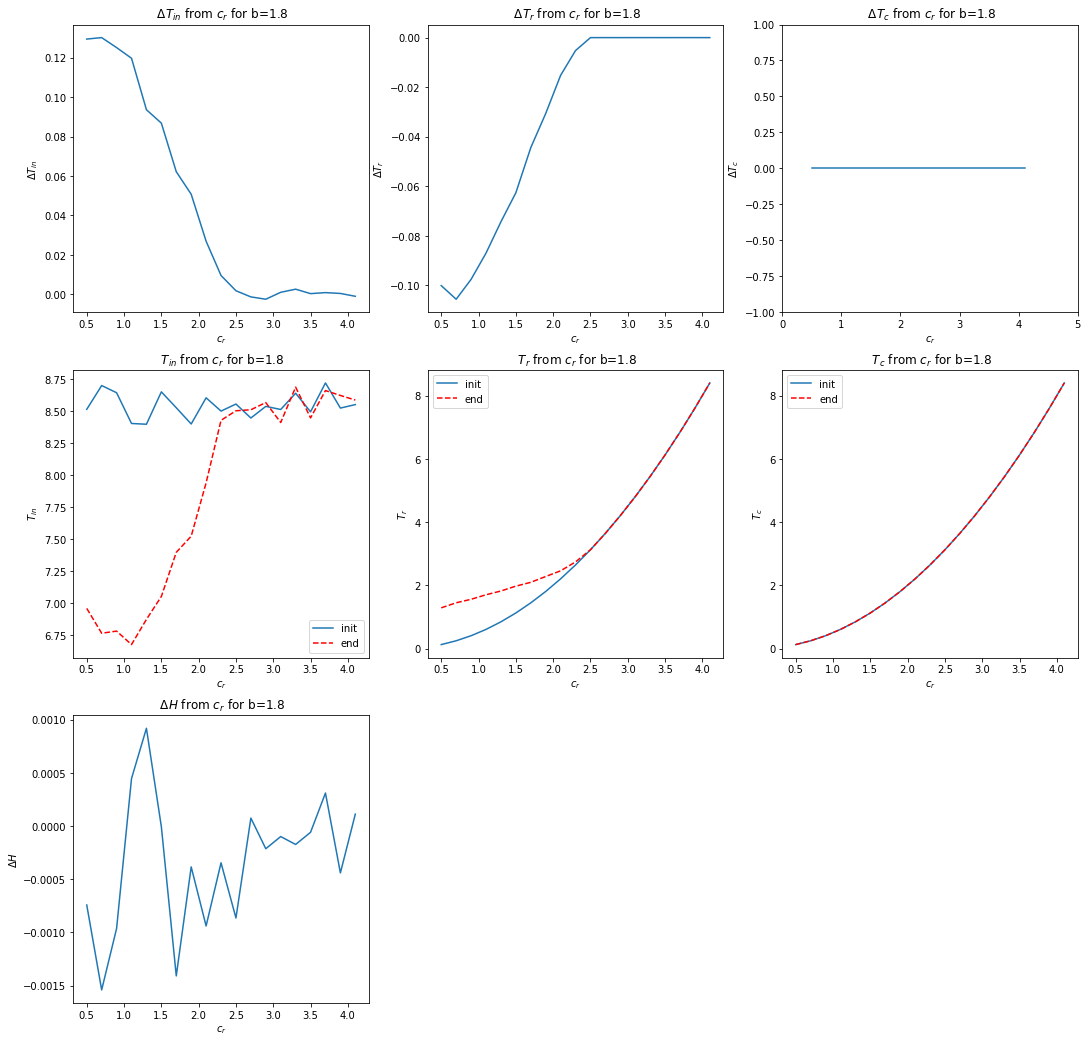

______________________________________________________________________________________________
dH =  -0.0005087484215043961


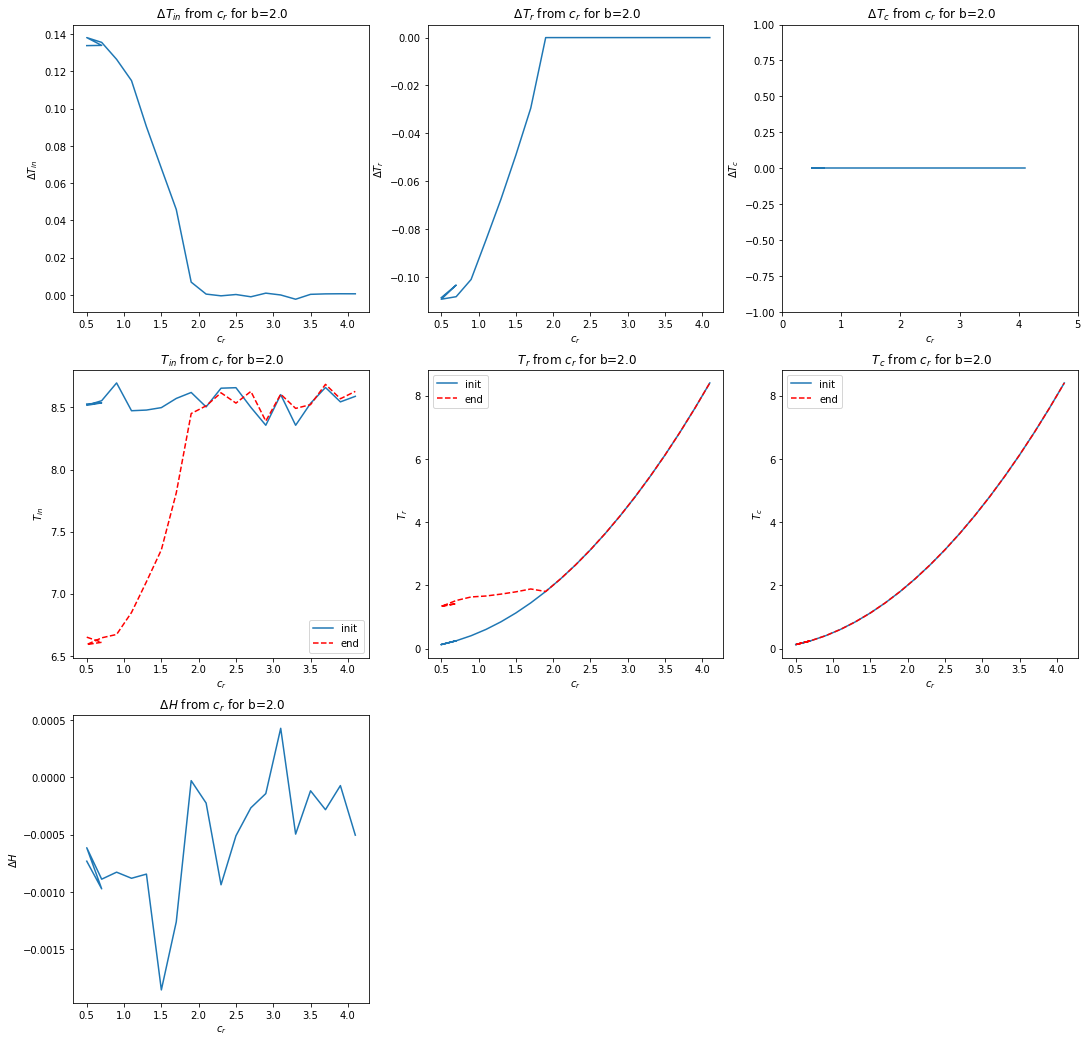

______________________________________________________________________________________________
dH =  -0.0006045601624427298


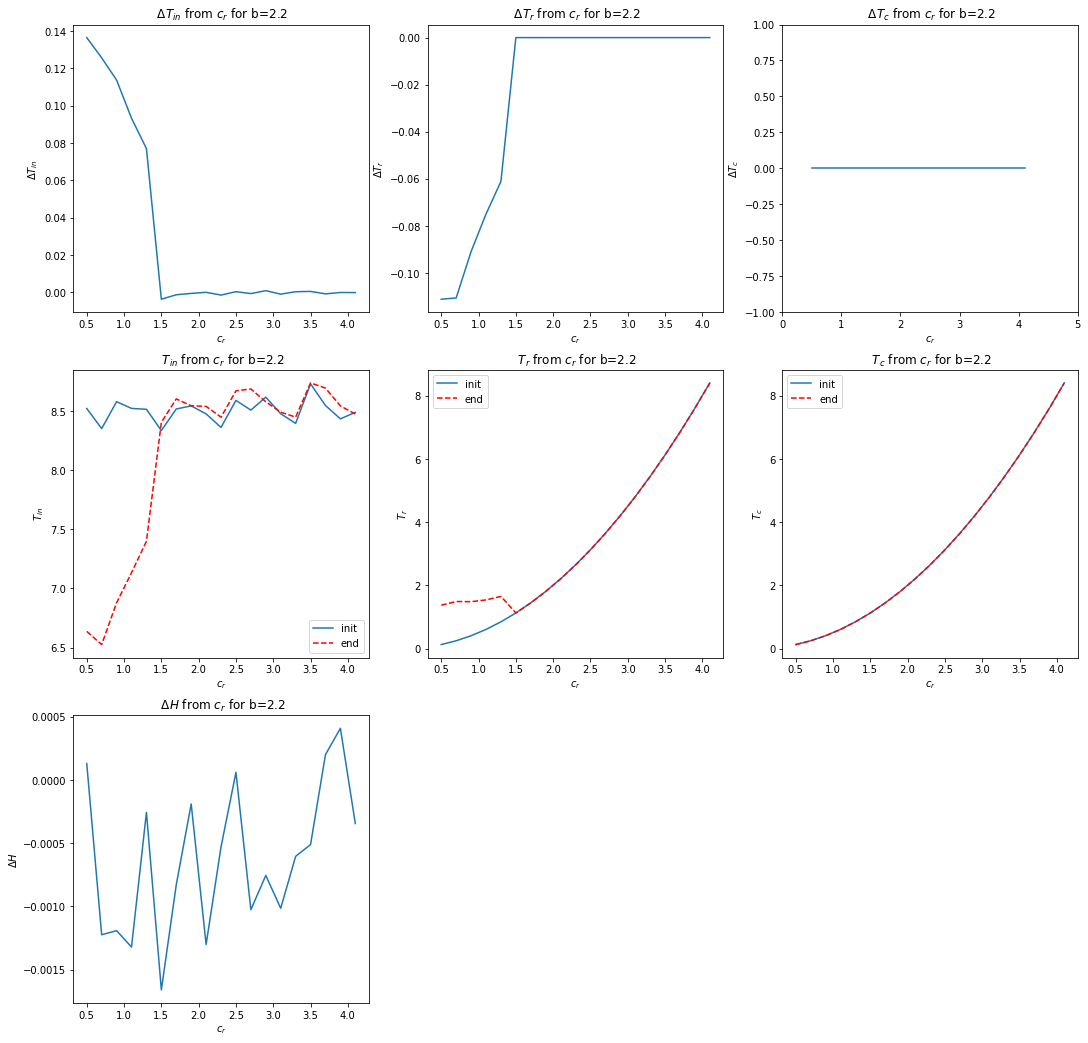

______________________________________________________________________________________________
dH =  -0.00044140174626613397


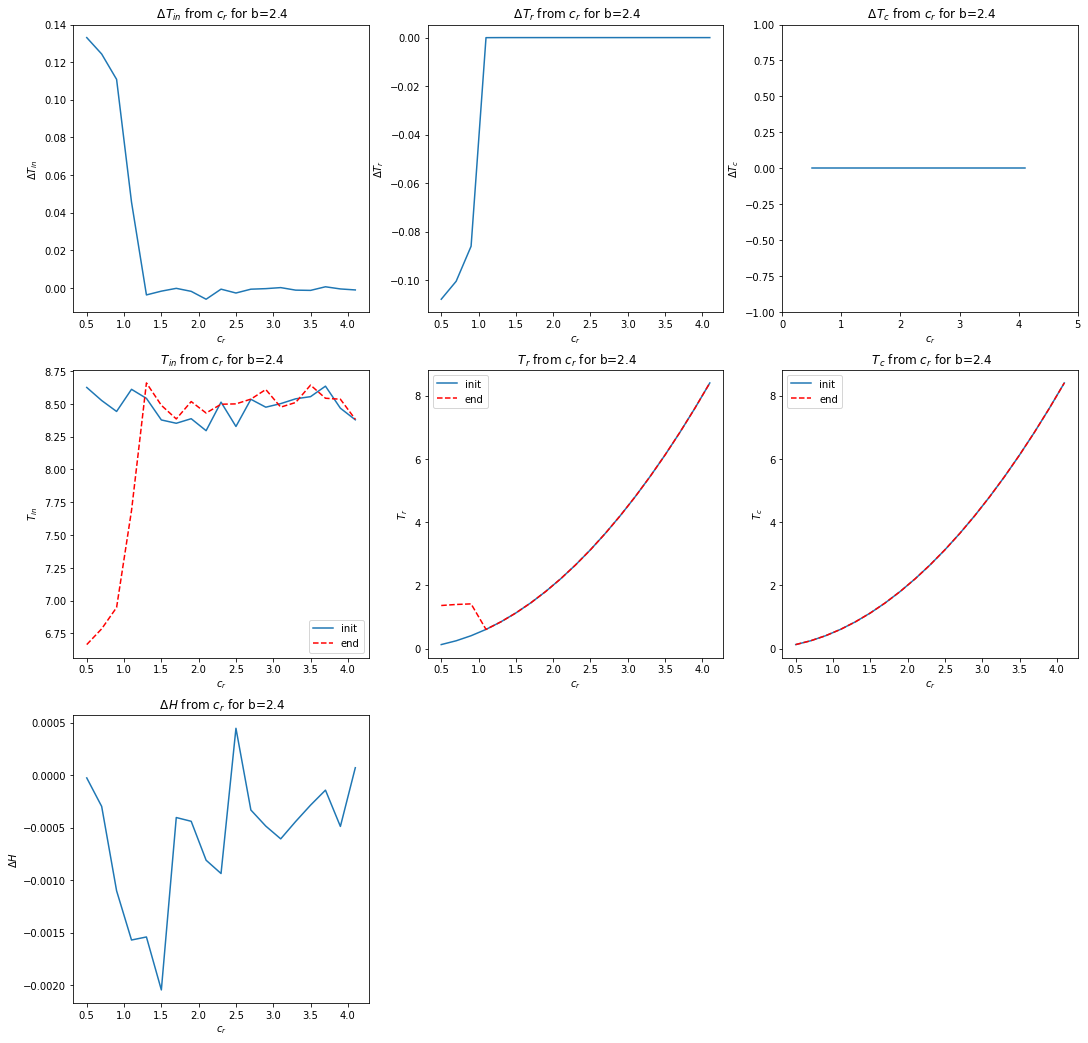

______________________________________________________________________________________________
dH =  -0.00037784447062935413


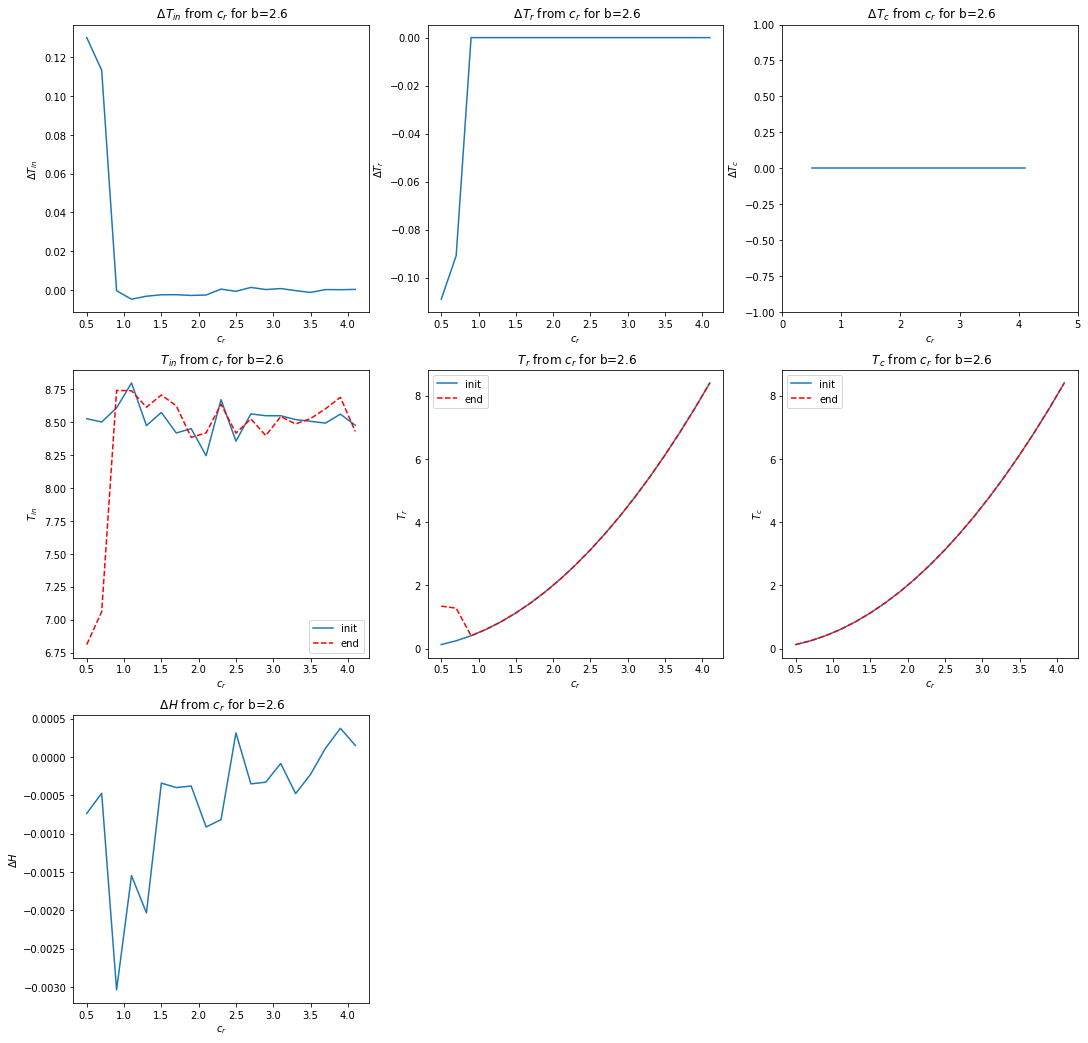

______________________________________________________________________________________________
dH =  -0.0003355926041328024


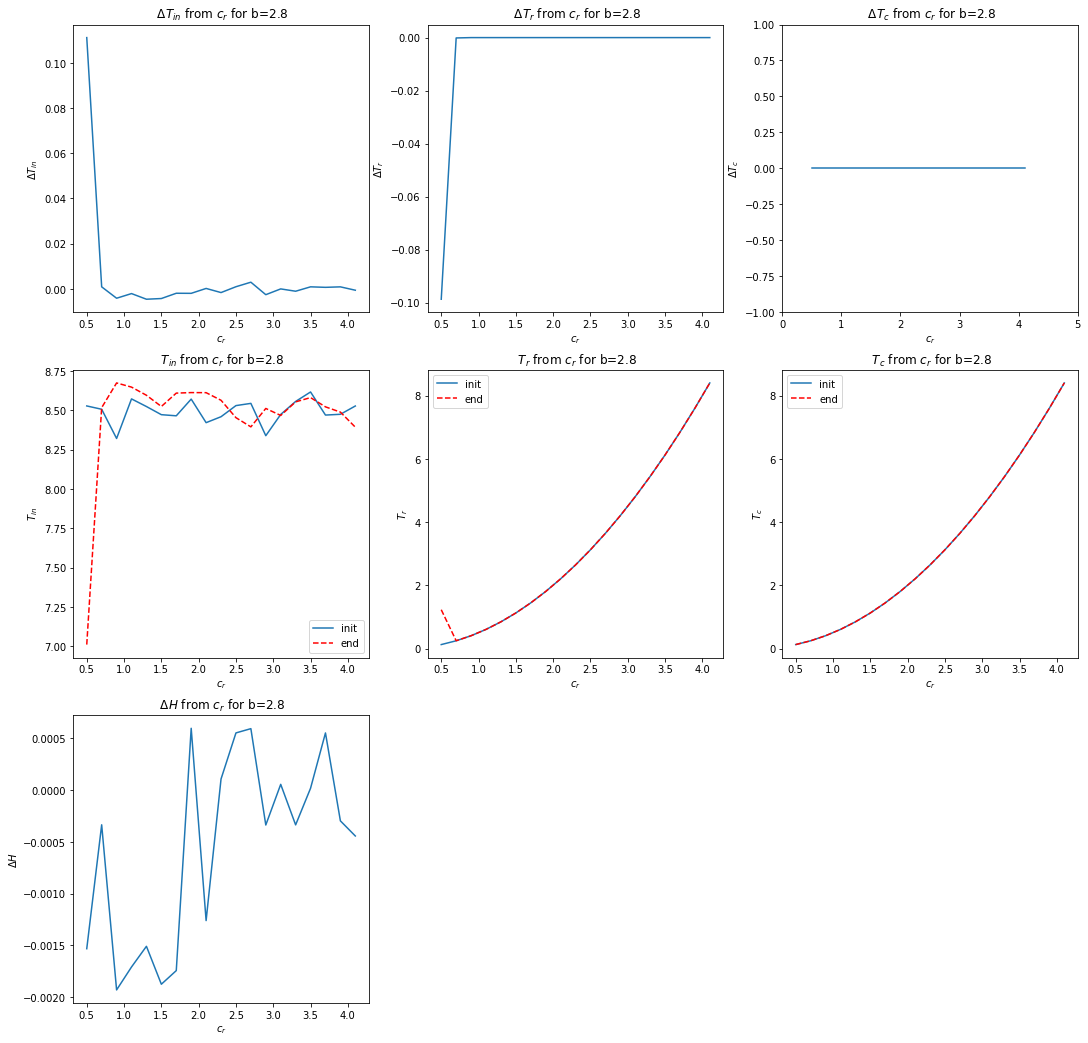

______________________________________________________________________________________________
dH =  -0.0007030321178174393


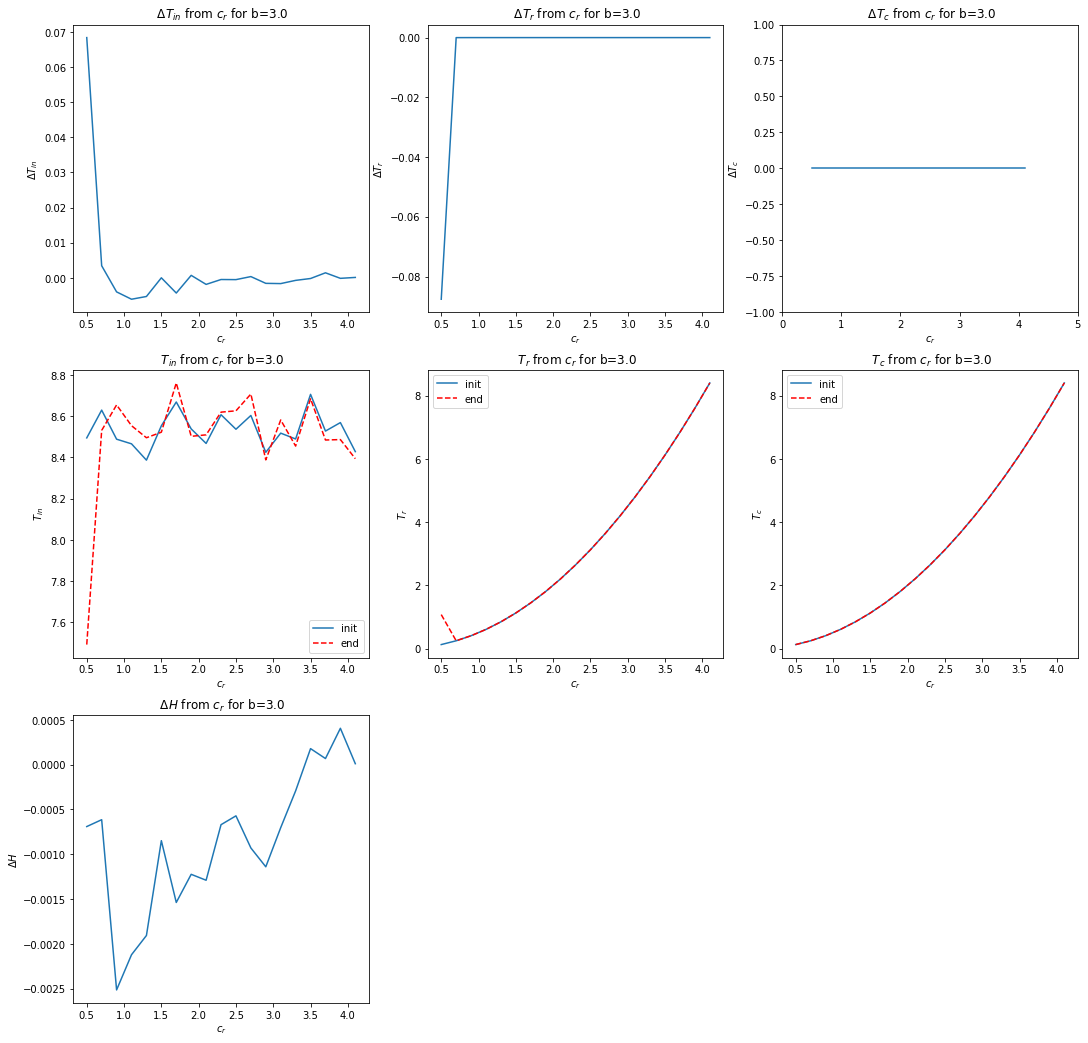

______________________________________________________________________________________________
dH =  -0.00041539809996741454


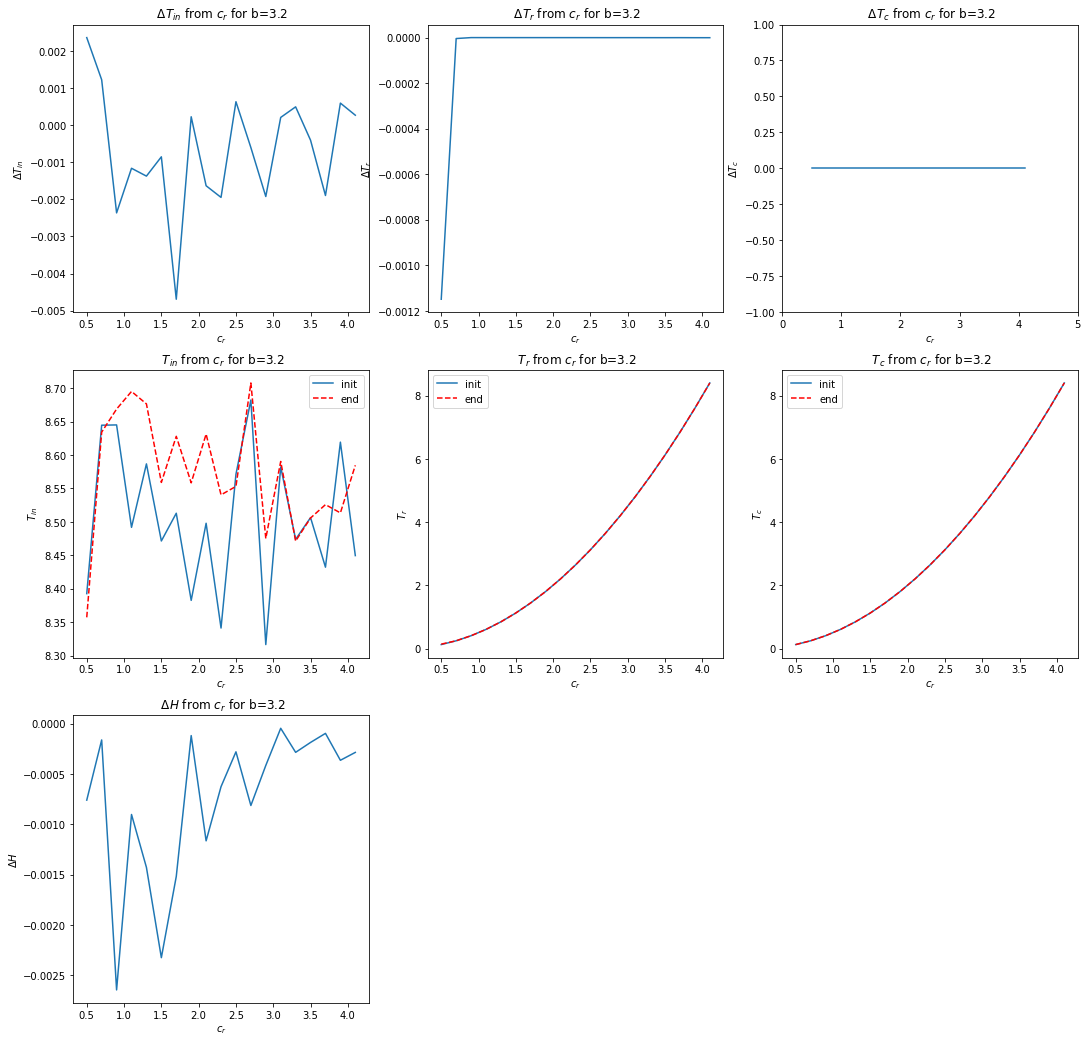

______________________________________________________________________________________________
dH =  -0.00016008306880297763


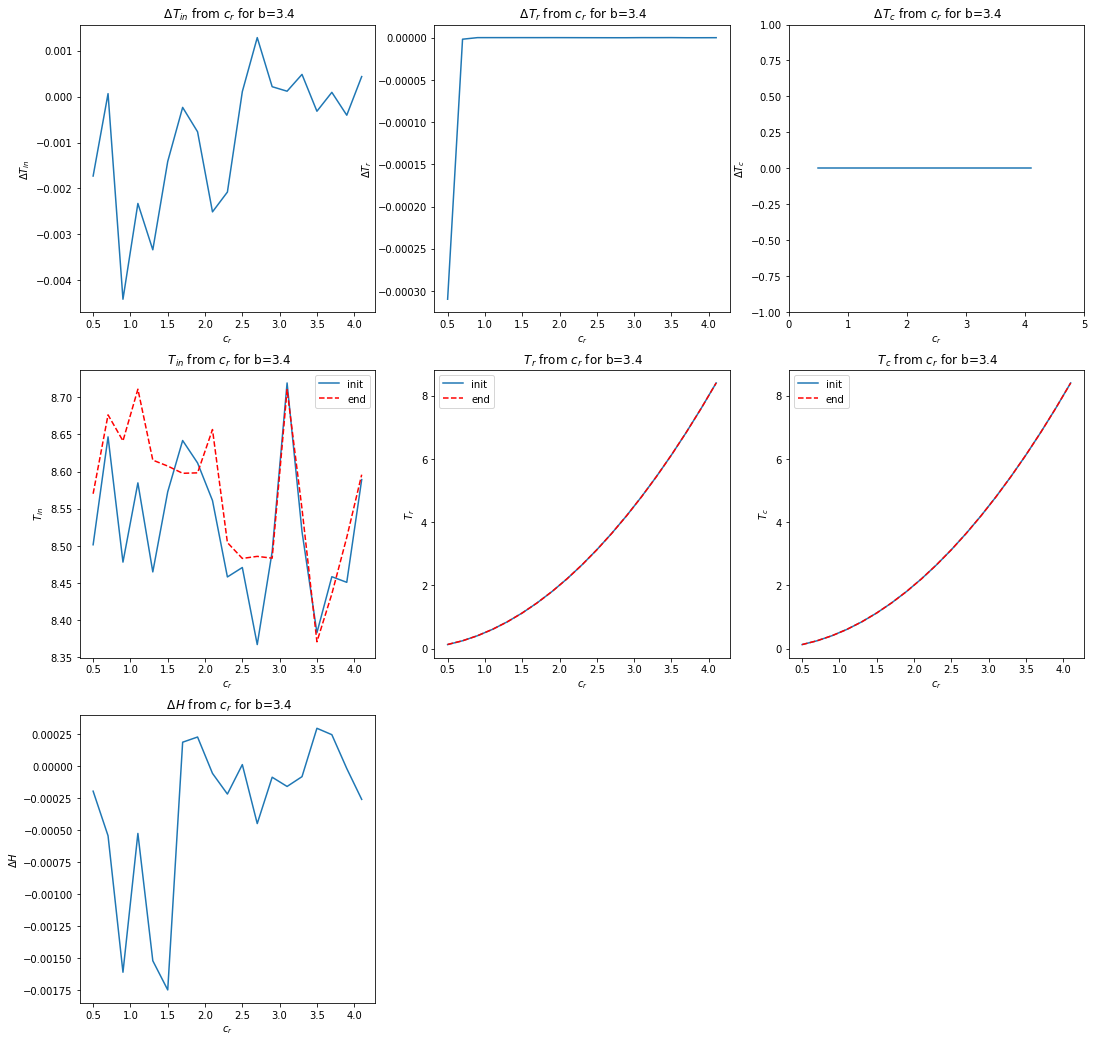

In [17]:
for b in sorted(result_b.keys()):
    print "______________________________________________________________________________________________"
    diff = []
    for c in (result_b[b]["H1"] - result_b[b]["H2"])/result_b[b]["H1"]:
         diff.append(np.median(c))
            
    print "dH = ", np.median(diff)
    
    T_in, T_c, T_r, T = [], [], [], []
    V, LD = [], []
    T_in1, T_c1, T_r1, T_in2, T_c2, T_r2 = [], [], [],[], [], []
    for c in (result_b[b]['T_in_1'] - result_b[b]['T_in_2'])/result_b[b]['H1']:
        T_in.append(np.median(c))
        
    for c in result_b[b]['T_in_1']:        
        T_in1.append(np.median(c))

    for c in result_b[b]['T_in_2']:                
        T_in2.append(np.median(c))


    for c in (result_b[b]['T_c_1'] - result_b[b]['T_c_2'])/result_b[b]['H1']:
        T_c.append(np.median(c))
        
    for c in result_b[b]['T_c_1']:
        T_c1.append(np.median(c))
    for c in result_b[b]['T_c_2']:
        T_c2.append(np.median(c))


    for c in (result_b[b]['T_r_1'] - result_b[b]['T_r_2'])/result_b[b]['H1']:
        T_r.append(np.median(c))
    
    for c in result_b[b]['T_r_1']:
        T_r1.append(np.median(c))
    
    for c in result_b[b]['T_r_2']:
        T_r2.append(np.median(c))


    for c in (result_b[b]['T_1'] - result_b[b]['T_2'])/result_b[b]['H1']:
         T.append(np.median(c))
    
    for c in (result_b[b]['V1'] - result_b[b]['V2'])/result_b[b]['H1']:
         V.append(np.median(c))
    
    for c in (result_b[b]['LD1'] - result_b[b]['LD2'])/result_b[b]['H1']:
         LD.append(np.median(c))
    
    
    plt.figure(1, figsize=(18,18))
    plt.subplot(331)
    plt.plot(result_b[b]['v'], T_in)
    plt.xlabel('$c_r$')
    plt.ylabel('$\Delta T_{in}$')    
    plt.title(' $\Delta T_{in}$ from $c_r$ for b=%s'%(b))
    
    plt.subplot(332)
    plt.plot(result_b[b]['v'], T_r)
    plt.xlabel('$c_r$')
    plt.ylabel('$\Delta T_r$')    
    plt.title(' $\Delta T_r$ from $c_r$ for b=%s'%(b))
    
    plt.subplot(333)
    plt.plot(result_b[b]['v'],T_c)
    plt.xlabel('$c_r$')
    plt.ylabel('$\Delta T_c$')    
    plt.axis((0,5, -1, 1))
    plt.title(' $\Delta T_c$ from $c_r$ for b=%s'%(b))
    
    plt.subplot(334)
    plt.plot(result_b[b]['v'], T_in1, label='init')
    plt.plot(result_b[b]['v'], T_in2,'r--',  label='end')
    #plt.plot(result_b[b]['v'],result_b[b]['T_in_2'])
    plt.xlabel('$c_r$')
    plt.ylabel('$T_{in}$')    
    plt.title(' $T_{in}$ from $c_r$ for b=%s'%(b))
    plt.legend()


    plt.subplot(335)
    plt.plot(result_b[b]['v'], T_r1, label='init')
    plt.plot(result_b[b]['v'], T_r2, 'r--', label='end')
    #plt.plot(result_b[b]['v'],result_b[b]['T_r_2'])
    plt.xlabel('$c_r$')
    plt.ylabel('$T_r$')    
    plt.title(' $T_r$ from $c_r$ for b=%s'%(b))
    plt.legend()


    plt.subplot(336)
    plt.plot(result_b[b]['v'],T_c1, label='init')
    plt.plot(result_b[b]['v'],T_c2, 'r--', label='end')
    #plt.plot(result_b[b]['v'],result_b[b]['T_c_2'])
    plt.xlabel('$c_r$')
    plt.ylabel('$T_c$')    
    plt.title(' $T_c$ from $c_r$ for b=%s'%(b))
    plt.legend()
    #plt.subplot(334)
    #plt.plot(result_b[b]['v'],T)
    #plt.plot(result_b[b]['v'],result_b[b]['T_c_2'])
    #plt.xlabel('$c_r$')
    #plt.ylabel('$\Delta T$')    
    #plt.title(' $\Delta T$ from $c_r$ for b=%s'%(b))
    
    
    plt.subplot(337)
    plt.plot(result_b[b]['v'],diff)
    #plt.plot(result_b[b]['v'],result_b[b]['T_c_2'])
    plt.xlabel('$c_r$')
    plt.ylabel('$\Delta H$')    
    plt.title(' $\Delta H$ from $c_r$ for b=%s'%(b))
    
    
    #plt.subplot(336)
    #plt.plot(result_b[b]['v'],V)
    #plt.plot(result_b[b]['v'],result_b[b]['T_c_2'])
    #plt.xlabel('$c_r$')
    #plt.ylabel('$\Delta V_{in} T$')    
    #plt.title(' $\Delta V_{in}$ from $c_r$ for b=%s'%(b))
    
    
    #plt.subplot(337)
    #plt.plot(result_b[b]['v'],LD)
    #plt.plot(result_b[b]['v'],result_b[b]['T_c_2'])
    #plt.xlabel('$c_r$')
    #plt.ylabel('$\Delta LD$')    
    #plt.title(' $\Delta LD$ from $c_r$ for b=%s'%(b))
    plt.show()

### Выводы:
    1. Изменение полной энергии всегда < 1%, что говорит о корректности модели;
    
    2. Кинетическая энергия центра масс системы не меняется;
    
    3. Внутрянняя кинетическая энергия молекул $T_{in}$:
        a. при небольших прицельных расстояних и малых скоростях уменьшается;
        b. при небольших прицельных расстояних и больших скоростях увеличивается;
        c. при больших прицельных расстояних и малых скоростях --- уменьшается;
        d. при больших прицельных расстояних и малых больших --- не изменяется;
        
    4. Кинетическая энергия относительного движения молекул $T_r$:
        a. при небольших прицельных расстояних и малых скоростях увеличивается;
        b. при небольших прицельных расстояних и больших скоростях уменьшается;
        c. при больших прицельных расстояних и малых скоростях --- увеличивается;
        d. при больших прицельных расстояних и малых больших --- не изменяется;
    
    5. Происходит перераспределение энергии между внутренней кинетическая энергия молекул $T_{in}$ и  кинетической энергией относительного движения молекул $T_r$

# Распределение энергии по степеням свободы

Посчитаем графики распределения по степеням свободы относительно полной энергии до и после столкновения.

Так же посчитаем $\Delta$ --- изменение энергии при столкновении по каждой из степеней:
    1. Поступательные
    2. Колебательные
    3. Вращательные

______________________________________________________________________________________________


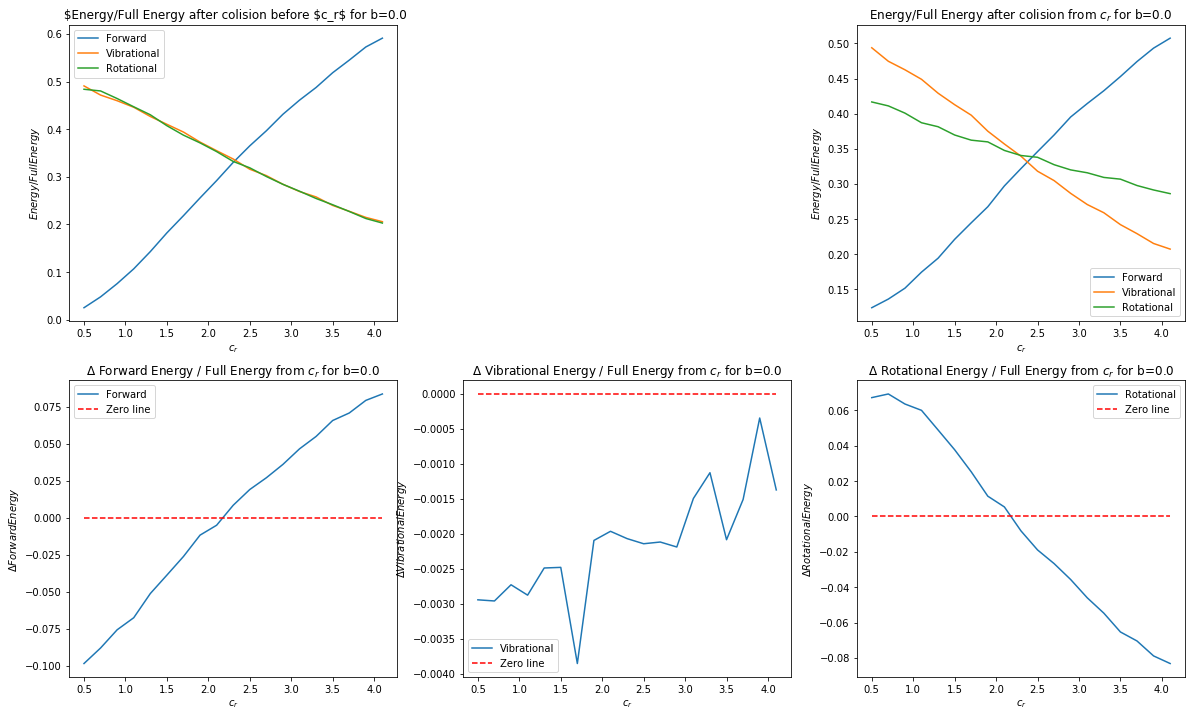

______________________________________________________________________________________________


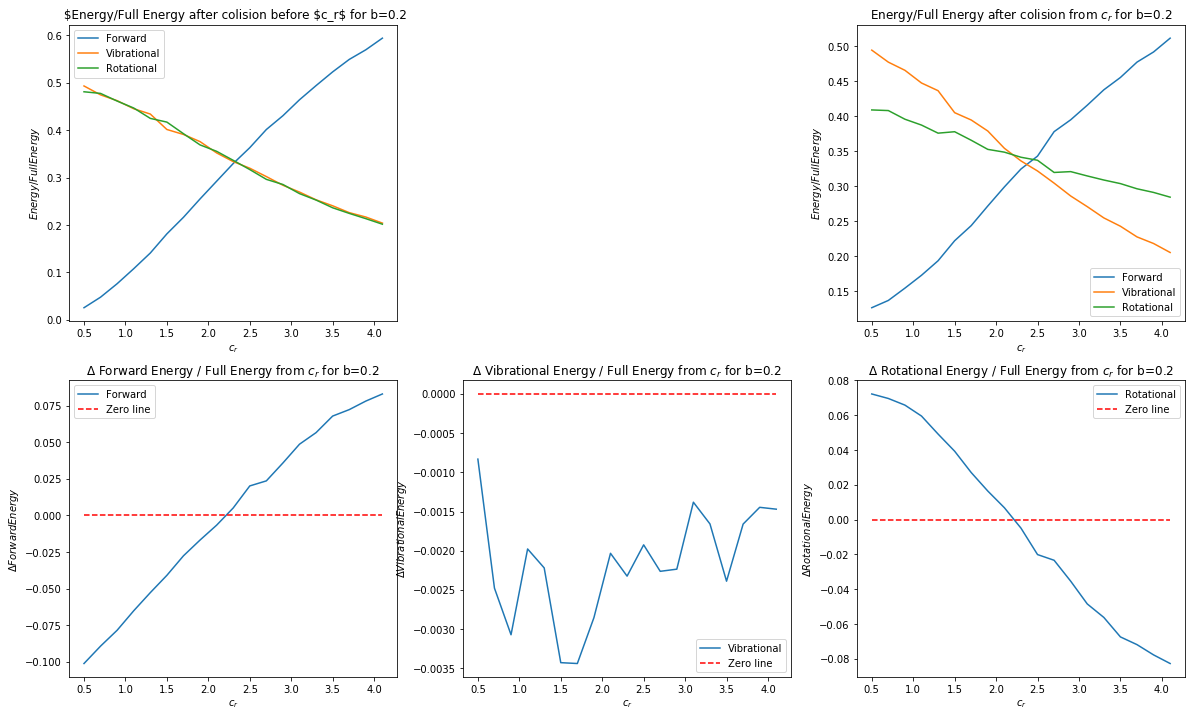

______________________________________________________________________________________________


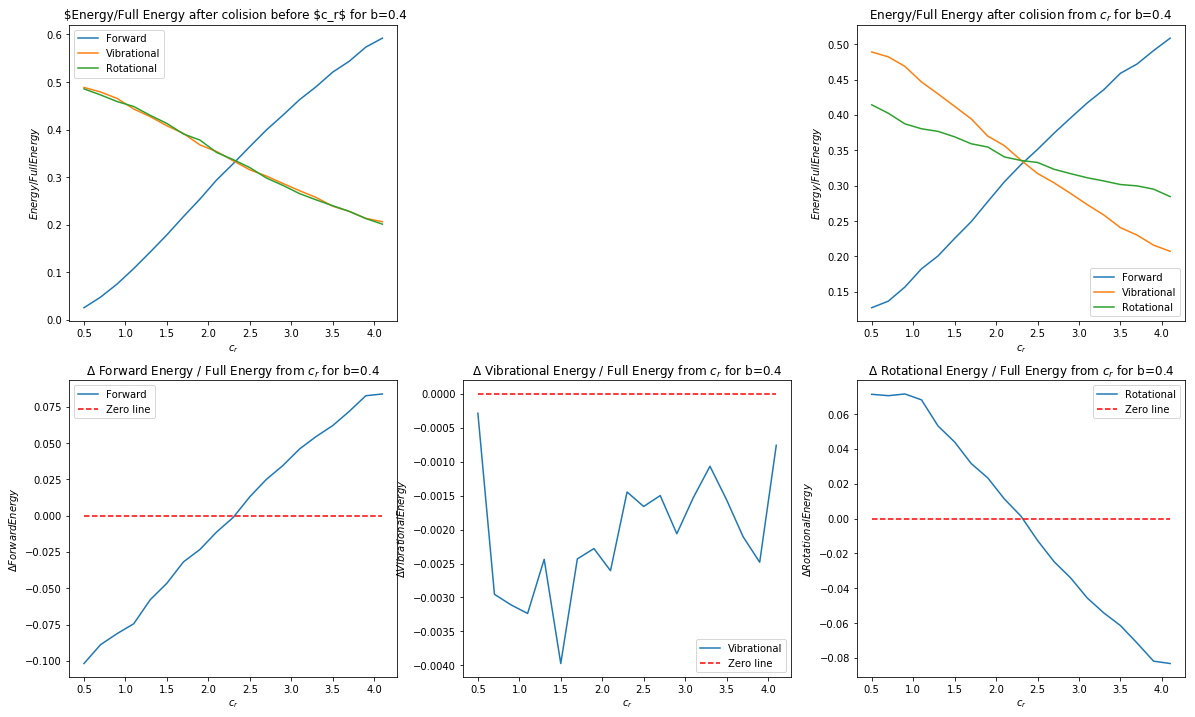

______________________________________________________________________________________________


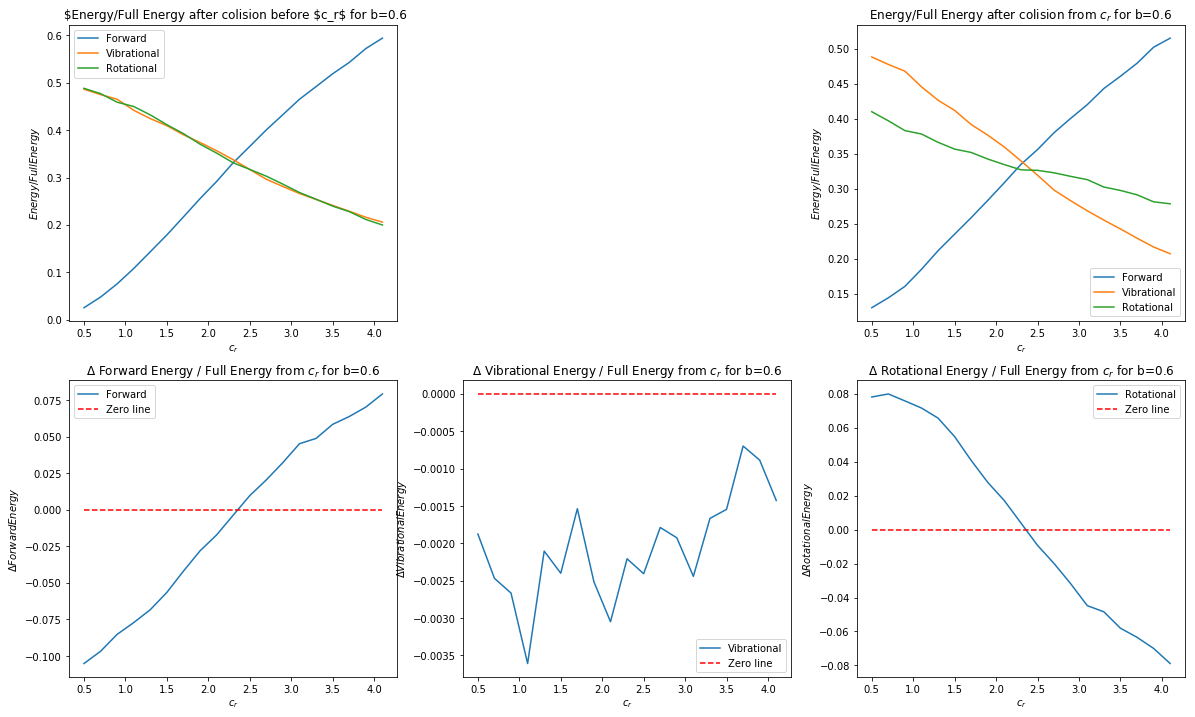

______________________________________________________________________________________________


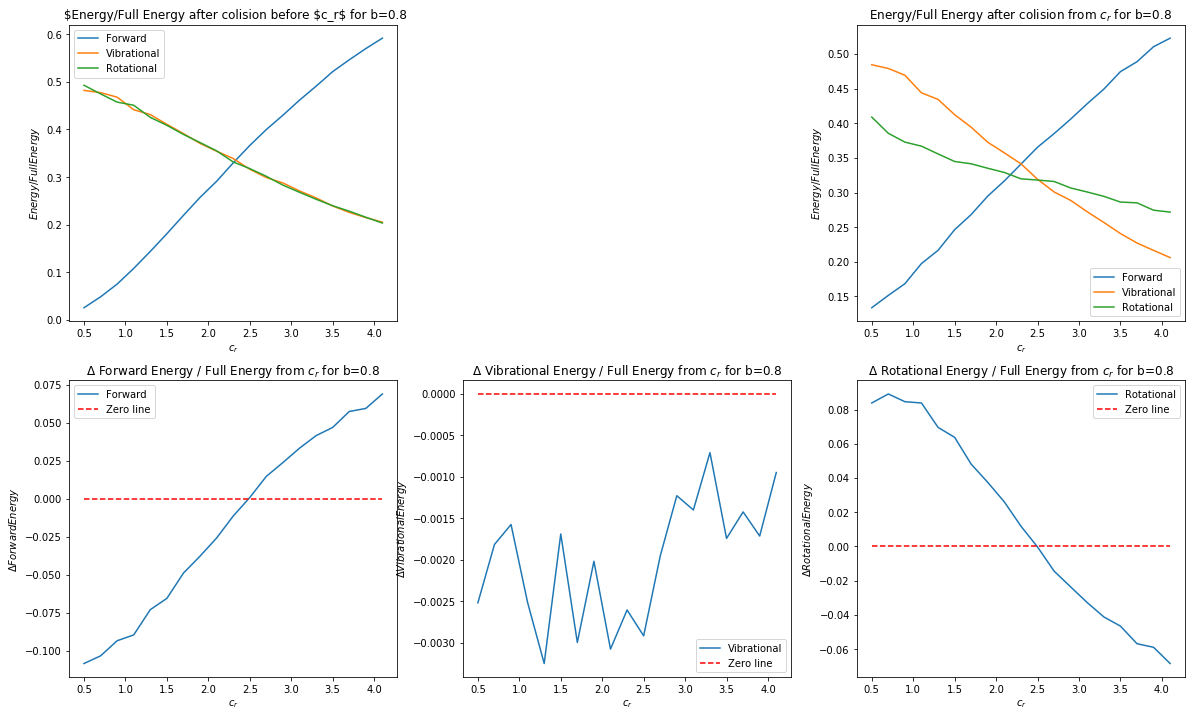

______________________________________________________________________________________________


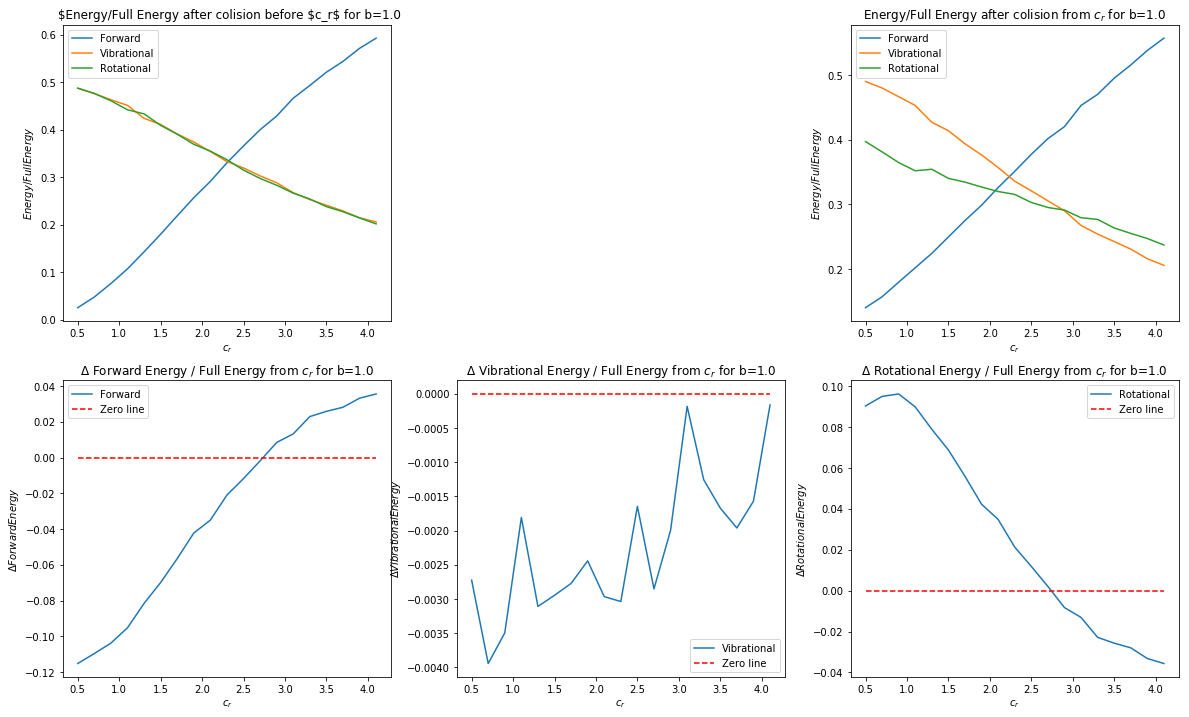

______________________________________________________________________________________________


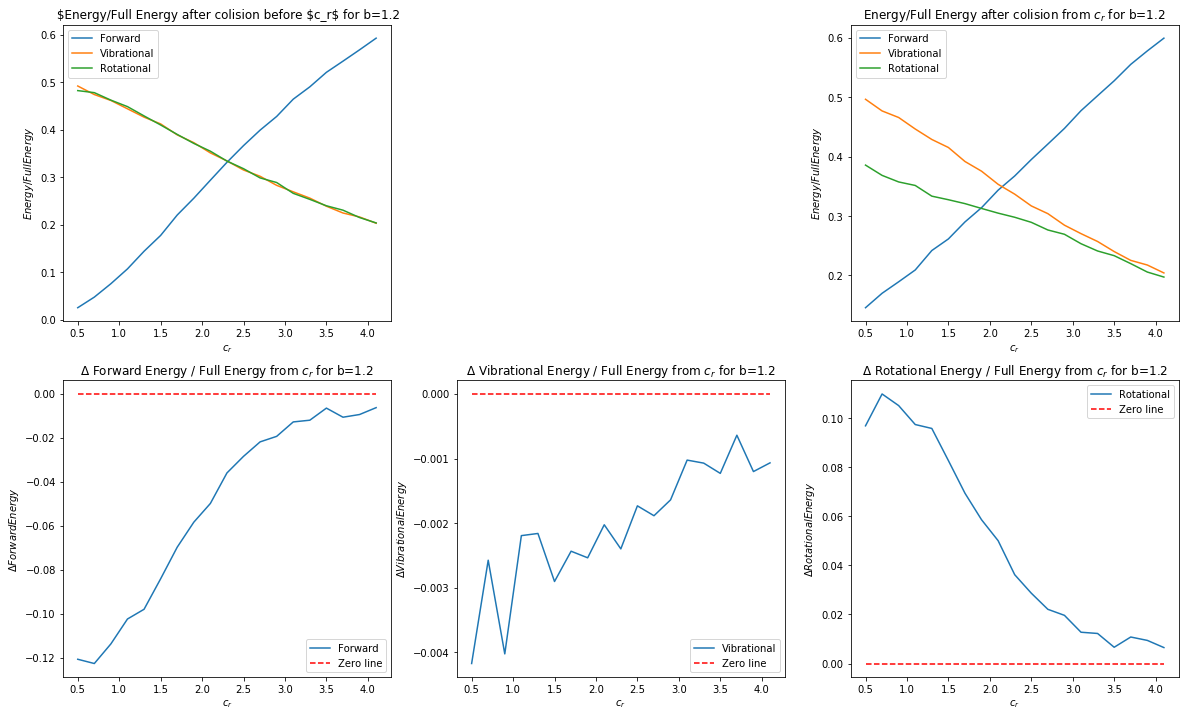

______________________________________________________________________________________________


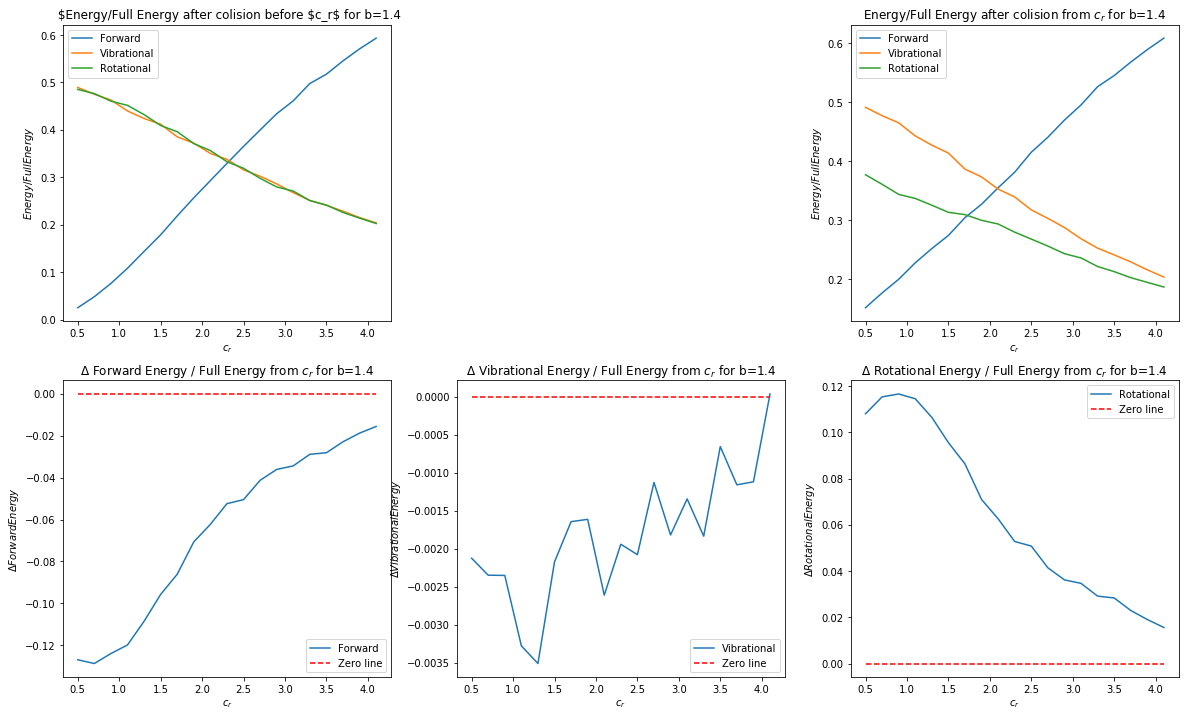

______________________________________________________________________________________________


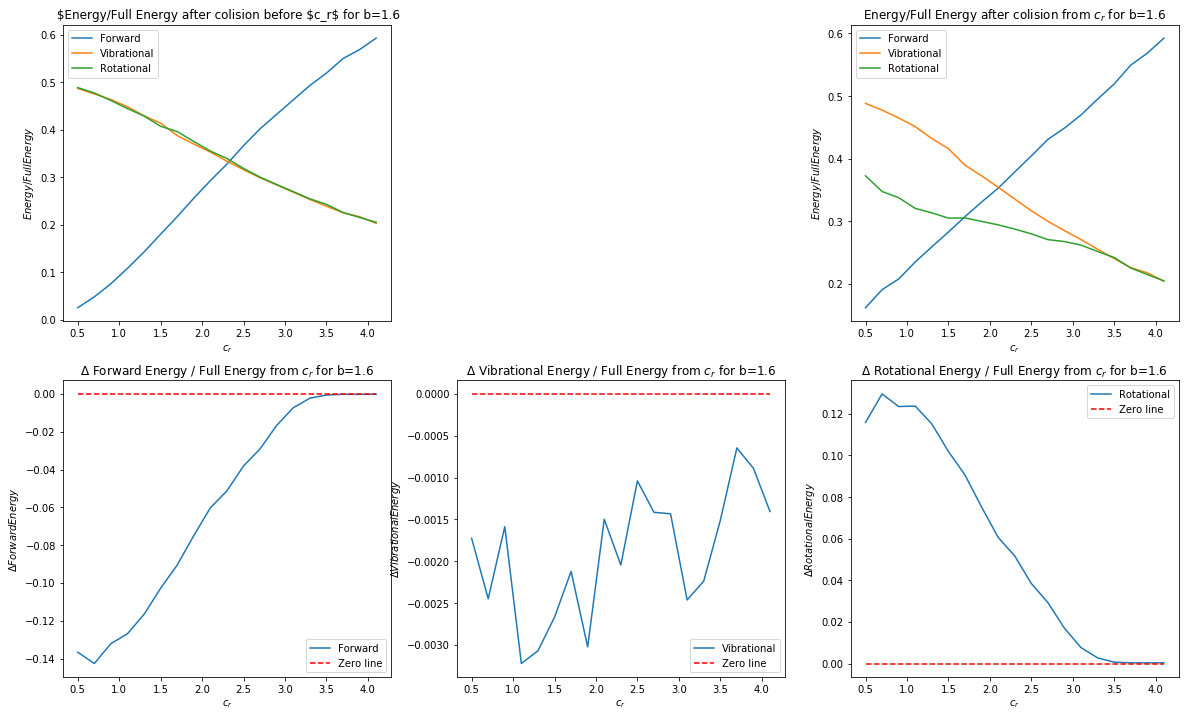

______________________________________________________________________________________________


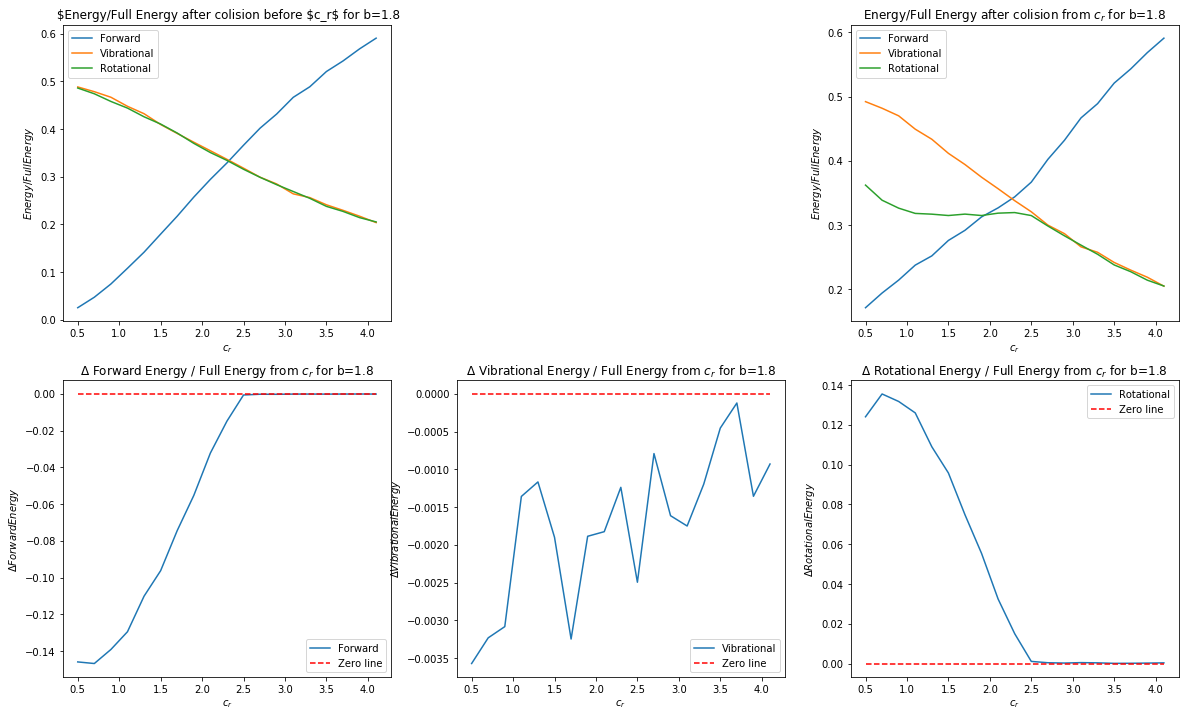

______________________________________________________________________________________________


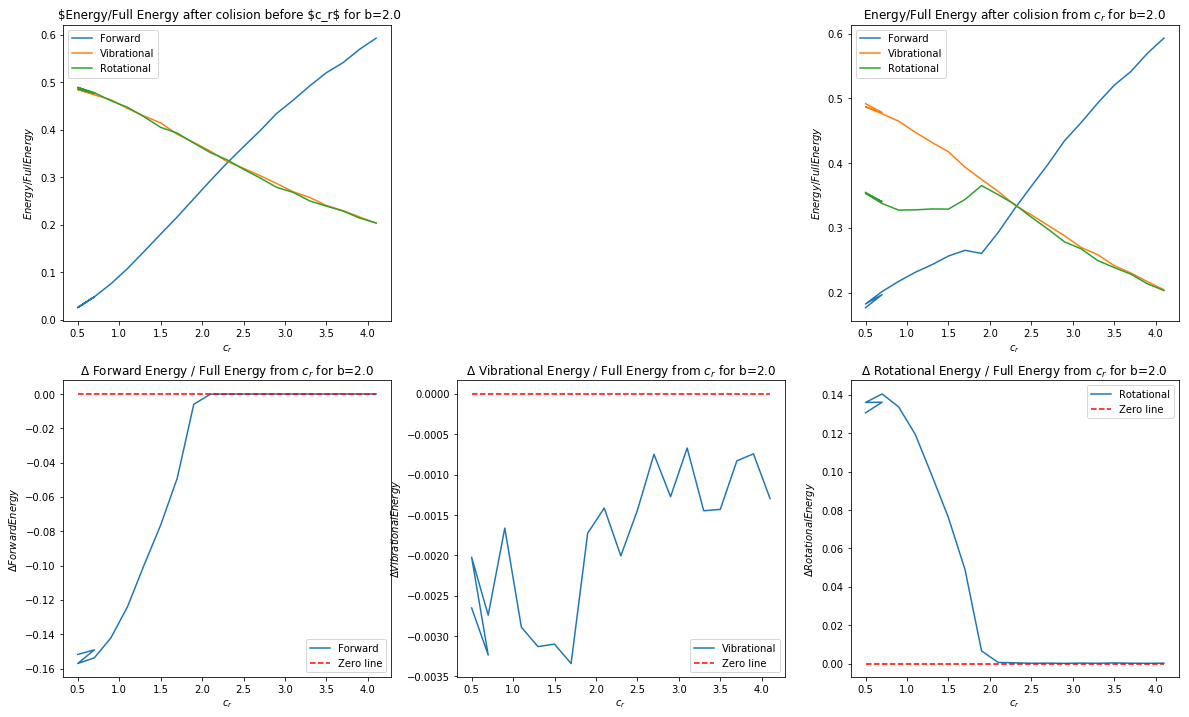

______________________________________________________________________________________________


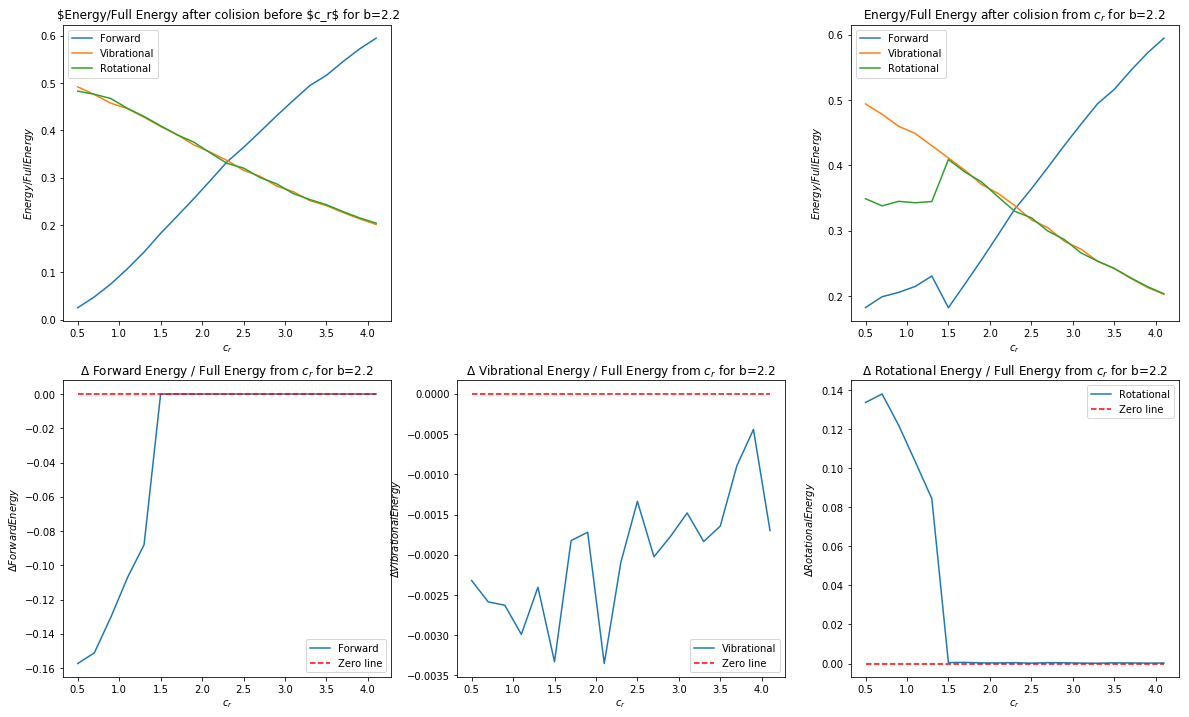

______________________________________________________________________________________________


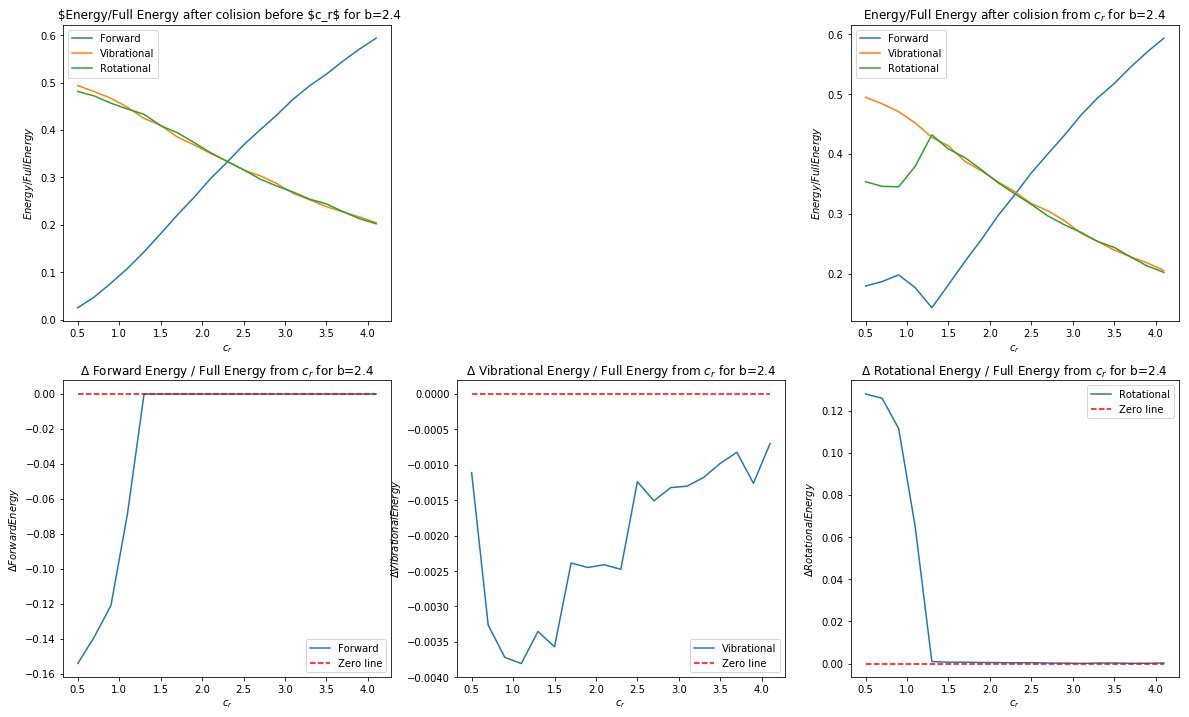

______________________________________________________________________________________________


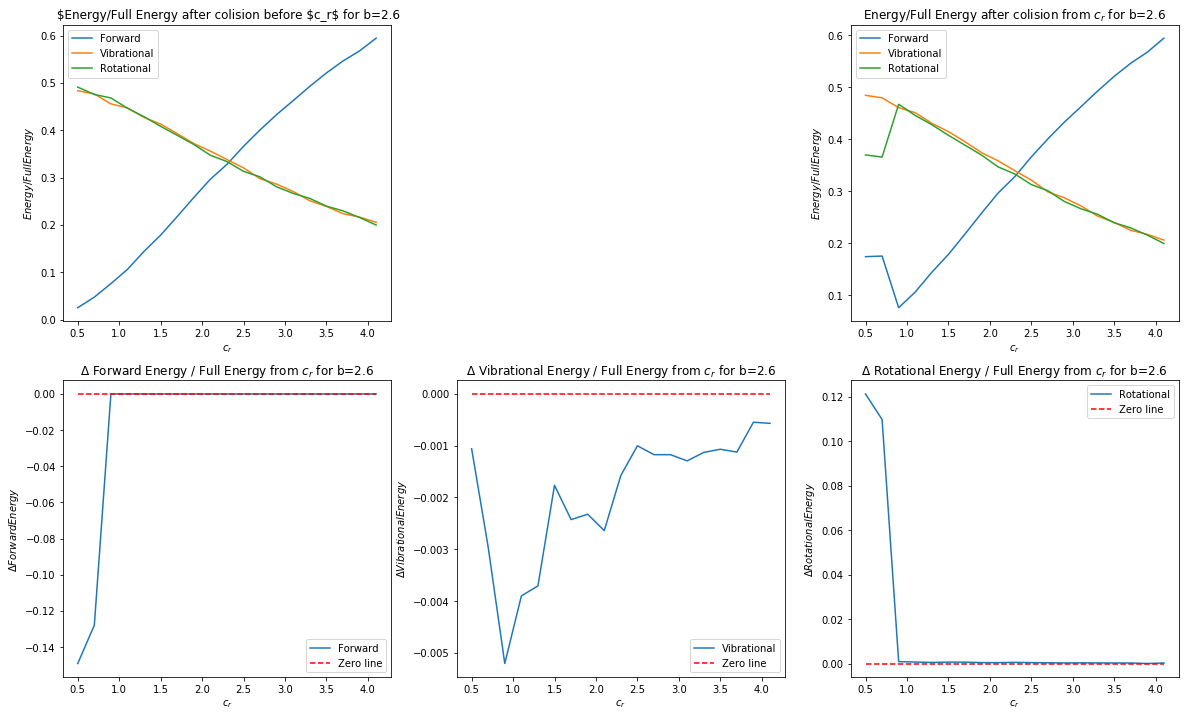

______________________________________________________________________________________________


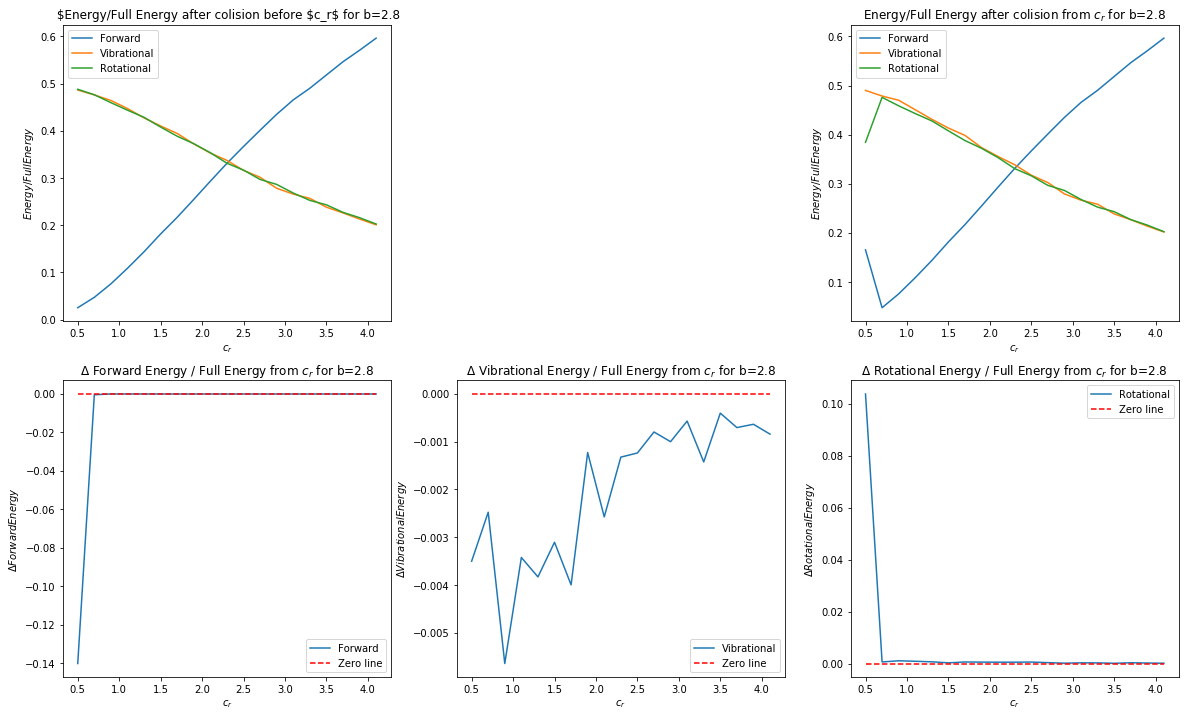

______________________________________________________________________________________________


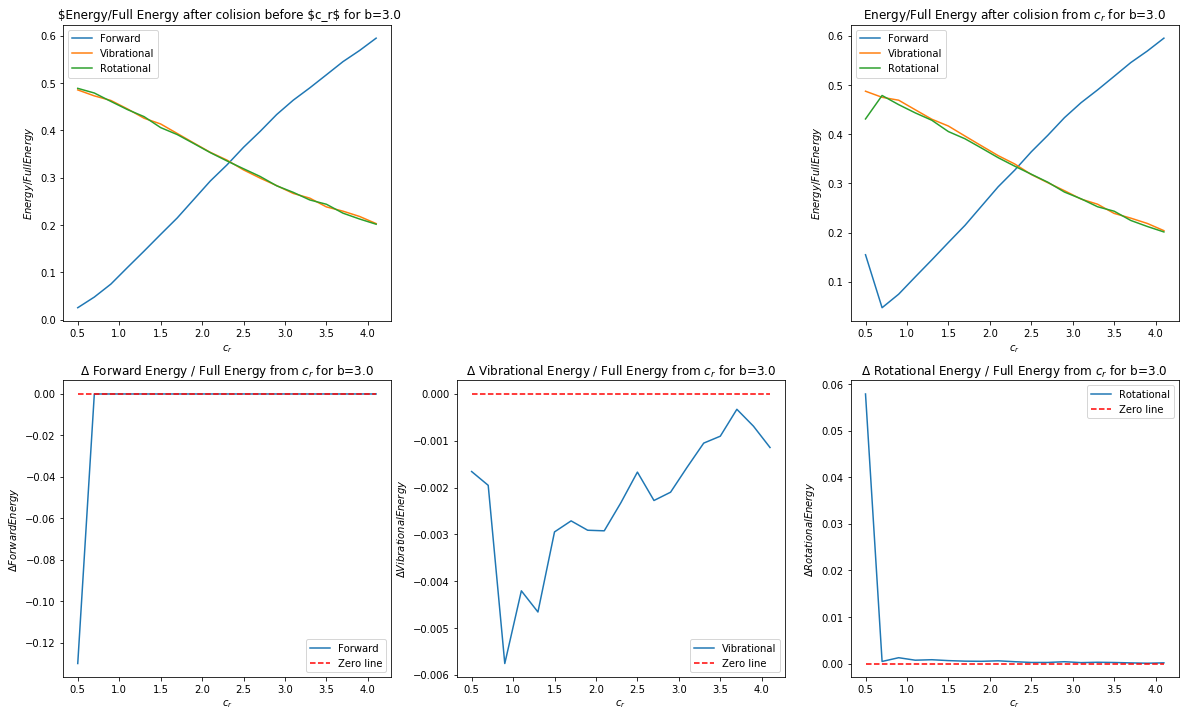

______________________________________________________________________________________________


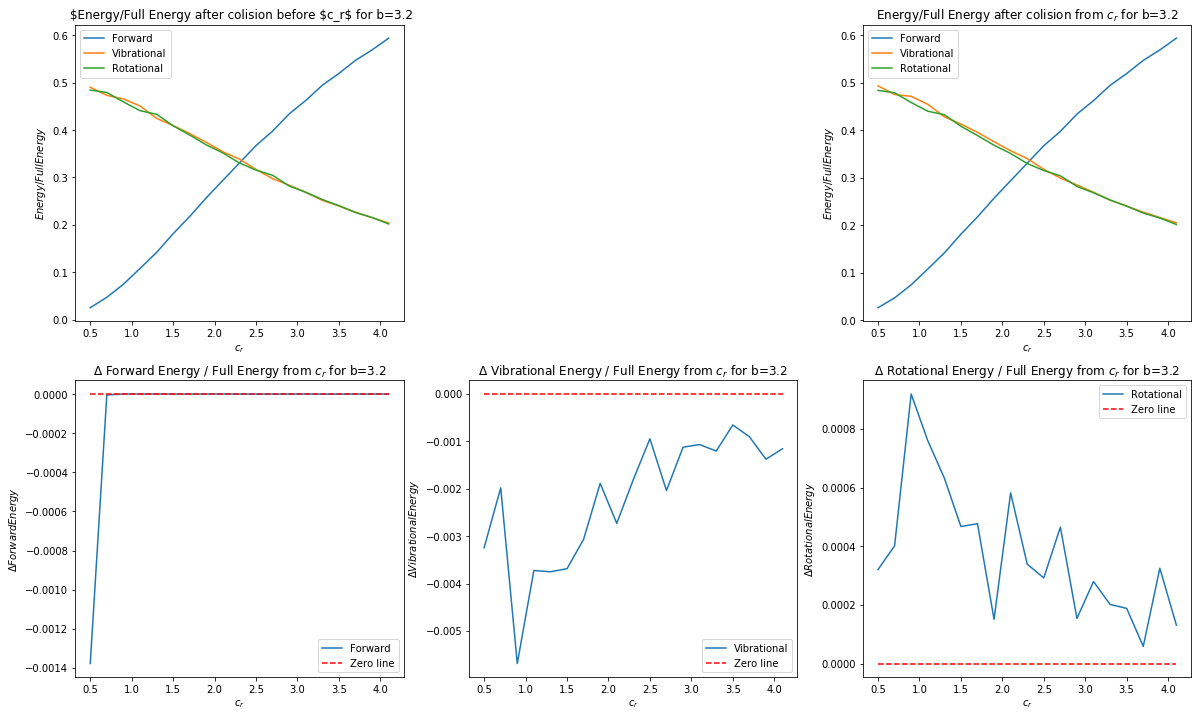

______________________________________________________________________________________________


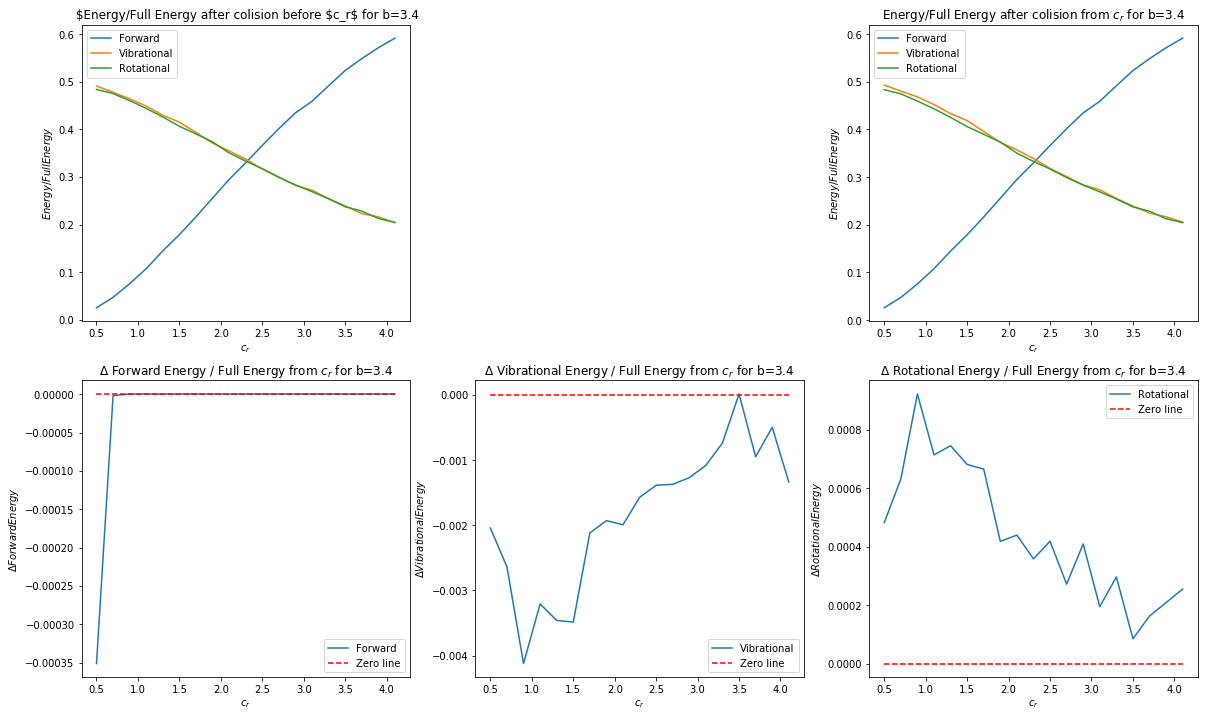

In [18]:
for b in sorted(result_b.keys()):
    print "______________________________________________________________________________________________"
    plt.figure(1, figsize=(20,12))
    plt.subplot(231)
    Fw=[np.mean(c) for c in result_b[b]['Fw1']/result_b[b]['H1']]
    Vib=[np.mean(c) for c in result_b[b]['Vib1']/result_b[b]['H1']]
    Rot=[np.mean(c) for c in result_b[b]['Rot1']/result_b[b]['H1']]
    plt.plot(result_b[b]['v'], Fw, label = "Forward")
    plt.plot(result_b[b]['v'], Vib, label = "Vibrational")
    plt.plot(result_b[b]['v'], Rot, label = "Rotational")
    plt.xlabel('$c_r$')
    plt.ylabel('$Energy / Full Energy$')    
    plt.legend()
    plt.title(' $Energy/Full Energy after colision before $c_r$ for b=%s'%(b))
    
    plt.subplot(233)
    Fw=[np.mean(c) for c in result_b[b]['Fw2']/result_b[b]['H1']]
    Vib=[np.mean(c) for c in result_b[b]['Vib2']/result_b[b]['H1']]
    Rot=[np.mean(c) for c in result_b[b]['Rot2']/result_b[b]['H1']]
    plt.plot(result_b[b]['v'], Fw, label = "Forward")
    plt.plot(result_b[b]['v'], Vib, label = "Vibrational")
    plt.plot(result_b[b]['v'], Rot, label = "Rotational")
    plt.xlabel('$c_r$')
    plt.ylabel('$Energy / Full Energy$')    
    plt.legend()
    plt.title('Energy/Full Energy after colision from $c_r$ for b=%s'%(b))
    
    plt.subplot(234)
    Fw=[np.mean(c) for c in (result_b[b]['Fw1']-result_b[b]['Fw2'])/result_b[b]['H1']]
    Vib=[np.mean(c) for c in (result_b[b]['Vib1'] - result_b[b]['Vib2'])/result_b[b]['H1']]
    Rot=[np.mean(c) for c in (result_b[b]['Rot1']-result_b[b]['Rot2'])/result_b[b]['H1']]
    plt.plot(result_b[b]['v'], Fw, label = "Forward")
    plt.plot([np.min(result_b[b]['v']),np.max(result_b[b]['v'])],[0,0], 'r--', label = "Zero line")
    plt.xlabel('$c_r$')
    plt.ylabel('$\Delta Forward Energy$')    
    plt.legend()
    plt.title('$\Delta$ Forward Energy / Full Energy from $c_r$ for b=%s'%(b))
    
    plt.subplot(235)
    plt.plot(result_b[b]['v'], Vib, label = "Vibrational")
    plt.plot([np.min(result_b[b]['v']),np.max(result_b[b]['v'])],[0,0], 'r--', label = "Zero line")
    plt.xlabel('$c_r$')
    plt.ylabel('$\Delta Vibrational Energy$')    
    plt.legend()
    plt.title('$\Delta$ Vibrational Energy / Full Energy from $c_r$ for b=%s'%(b))

    plt.subplot(236)
    plt.plot(result_b[b]['v'], Rot, label = "Rotational")
    plt.plot([np.min(result_b[b]['v']),np.max(result_b[b]['v'])],[0,0], 'r--', label = "Zero line")
    plt.xlabel('$c_r$')
    plt.ylabel('$\Delta Rotational Energy$')    
    plt.legend()
    plt.title('$\Delta$ Rotational Energy / Full Energy from $c_r$ for b=%s'%(b))
    plt.show()

### Выводы:
    1. Изменение колебательной энергии всегда меньше 1%, можно считать, что она не меняется.
    
    2. Поступательная энергия:
        a. При малых прицельных расстояниях и малых относительных скоростях --- увеличивется;
        b. При малых прицельных расстояниях и больших относительных скоростях --- уменьшается;
        c. При больших прицельных расстояниях и малых относительных скоростях --- увеличивется;
        d. При больших прицельных расстояниях и больших относительных скоростях --- неизменяется;
        
    3. Вращательная энергия:
        a. При малых прицельных расстояниях и малых относительных скоростях --- уменьшается
        b. При малых прицельных расстояниях и больших относительных скоростях --- увеличивется;;
        c. При больших прицельных расстояниях и малых относительных скоростях --- уменьшается;
        d. При больших прицельных расстояниях и больших относительных скоростях --- неизменяется;
        
    4. Перераспределение энергии происходит между вращательными и поступательными степенями свободы.